# Inversion example of diffusion + tracer mineral (uranium salt) dissolution inversion in 2d

- Importation of the required modules

In [20]:
import copy
import logging
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from typing import Dict, Generator, Iterable, List, Sequence, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import pyrtid.utils.spde as spde
import scipy as sp
import shapely
import tomli
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.axes import Axes
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from pyesmda import get_ensemble_variance
from pyesmda.localization import (
    CorrelationBasedLocalization,
    CorrelationTempering,
    FixedLocalization,
    NoLocalization,
    distances_to_weights_beta_cumulative,
    gc_correlation_tempering_positive,
)
from pyrtid.inverse.params import (
    get_gridded_archived_gradients,
    get_param_values,
)
from pyrtid.inverse.preconditioner import get_theta_init_normal
from pyrtid.inverse.regularization import (
    SparseInvCovarianceMatrix,
)
from pyrtid.inverse.regularization.covariances import get_explained_var
from pyrtid.utils import (
    RectilinearGrid,
    StrEnum,
    create_selections_array_2d,
    get_polygon_selection_with_dilation_2d,
    indices_to_node_number,
)
from pyrtid.utils.types import NDArrayFloat, NDArrayInt
from pyrtid.utils.wellfield import gen_wells_coordinates
from scipy.interpolate import interp1d
from scipy.sparse import csc_array, csr_array, lil_array
from scipy.spatial import distance_matrix
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import box as ShapelyBox
from shapely.ops import cascaded_union
from sksparse.cholmod import cholesky

- Set-up logging level

In [21]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")
print("This is a print test")

INFO:root:this is a logging test


This is a print test


- Check package/software versions

In [22]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.8.3
INFO:root:nested_grid_plotter         = 1.1.1
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Random number generator with a given seed for reproducible results

In [23]:
rng = np.random.default_rng(2023)

- Create a directory to store the exported figures

In [24]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [25]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Define a flag to turn off/on the complete notebook run

In [26]:
class Lg(StrEnum):
    FRENCH = "french"
    ENGLISH = "english"


with open("config.toml", "rb") as f:
    data = tomli.load(f)

    is_run_all = data["is_run_all"]
    # whether to run asm inversion
    is_run_asm = data["is_run_asm"] or is_run_all
    # whether to run pcga inversion
    is_run_pcga = data["is_run_pcga"] or is_run_all
    # whether to run esmda inversion
    is_run_esmda = data["is_run_esmda"] or is_run_all
    # whether to run sies inversion
    is_run_sies = data["is_run_sies"] or is_run_all
    # whether to run the code parallel
    is_parallel = data["is_parallel"]
    # number of workers for the parallel execution
    max_workers = data["max_workers"]
    # language for the plot labels
    language = ["language"]
    # number of principal component for the inversion with PCGA
    n_pc = data["n_pc"]
    # number of fields for the ensemble smoothers
    n_fields_es = data["n_fields_es"]

    # whether to use esmda_restricte_step or not
    esmda_variant = {"base": "base", "dmc": "dmc", "rs": "rs"}[
        data.get("esmda_variant", "base")
    ]
    # if true, an adaptive localization is used
    esmda_localization_strategy = data.get("esmda_localization_strategy", "fixed")

    # whether to use grey scale rather than colors
    is_gray_scale = data["is_gray_scale"]

    # Needed when we generate the ensemble
    is_run_ensembles = is_run_esmda or is_run_sies

    # whether to run the old version of PCGA
    is_run_pcga_old = data["is_run_pcga_old"]

    # simulation duration
    duration_in_days = data.get("duration_in_days", 300)
    duration_in_days_inv = data.get("duration_in_days_inv", 150)  # used for inversion

    # whether to export animations or not
    is_export_animations = data["is_export_animations"]

    # whether to use the exact field variance of not
    is_use_exact_std = data.get("is_use_exact_std", True)


if is_gray_scale:
    jet_cmap = plt.get_cmap("Greys")
    # make symmetric cmap for greys
    top = plt.get_cmap("Greys_r", 128)
    bottom = plt.get_cmap("Greys", 128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
    bwr_cmap = mpl.colors.ListedColormap(newcolors, name="SymmetricGreys")
else:
    jet_cmap = plt.get_cmap("jet")
    bwr_cmap = plt.get_cmap("bwr")

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [27]:
# Grid
nx = (
    57 + 4 * 2
)  # number of voxels along the x axis + 4 * 2 for the borders (regularization)
ny = 57 + 4 * 2  # number of voxels along the y axis
nz = 1
dx = 5.0  # voxel dimension along the x axis
dy = 5.0  # voxel dimension along the y axis
dz = 5.0

geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)
grid = RectilinearGrid(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz)

# Timesteps
duration_in_seconds = duration_in_days * 3600 * 24
duration_in_seconds_inv = duration_in_days_inv * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_min = dt_init / 2
dt_max = dt_init * 2
courant_factor = 10

# Hydro parameters
flow_regime = "transient"
diffusion_coef = 1e-10  # general initial diffusion coefficient [m2/s]
permeability = 1e-4  # general permeability
porosity = 0.23  # general porosity [fraction]
storage_coefficient = 1e-3

# Chemistry parameters
c0 = 1.0e-10  # general initial concentration [molal]
c_inj = 1.0  # molal
stocoef = 300

M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -1e-7  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 3.2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]

In [28]:
Ks

0.000630957344480193

- Creation of a network of injectors and producers in shape of hexagons.

In [29]:
# locations in the grid
# selection = index of cells to select. Cells are sorted by y, and if that's equal by x (increasing order).
cell_radius = 40.0
inj_grid_coordinates, prod_grid_coordinates, prod_cell_polygons = gen_wells_coordinates(
    -5.0,
    85.0,
    175.0,
    235.0,
    radius=cell_radius,
    rotation=-30,
    selection=[0, 1, 2, 4, 5, 6, 7],
)

prod_cell_polygons = [np.array(poly) for poly in prod_cell_polygons]

- Extend selection by 25 meters to take the "real" lixiviation volume into account

In [30]:
buffer_distance_in_m = 25


def extend_polygons(polygons, buffer_in_m) -> List[NDArrayFloat]:
    # _ext_coords = [
    #     np.array(shapely.geometry.Polygon(np.array(_poly)).buffer(
    #         buffer_distance_in_m, cap_style=shapely.geometry.CAP_STYLE.round
    #     ).boundary.xy).T
    #     for _poly in polygons
    # ]

    # convert to shapely
    shp_polys = [shapely.geometry.Polygon(p) for p in polygons]

    # union of all extended polygons
    full_poly = shapely.ops.unary_union(shp_polys).buffer(
        buffer_distance_in_m, cap_style=shapely.geometry.CAP_STYLE.round
    )

    # prevent overlapping using voronoi approach
    _tmp = shapely.voronoi_polygons(
        shapely.geometry.MultiPoint([p.centroid.xy for p in shp_polys]),
        extend_to=full_poly,
    )

    # preserve the order
    pts = np.array([_poly.centroid.xy for _poly in shp_polys])
    # sequence of argsort
    old_order = []
    # we look for the polygon for which the center coordiantes are the closest for the
    # new polygon
    for _poly in _tmp.geoms:
        diff = pts - np.array(_poly.centroid.xy)
        old_order.append(np.argmin(np.sum(diff**2, axis=1)))

    return [
        np.array(_tmp.geoms[i].intersection(full_poly).boundary.xy).T
        for i in np.argsort(old_order)
    ]


prod_cell_polygons_ext25m = extend_polygons(prod_cell_polygons, buffer_distance_in_m)

- Get the indices in the grid

In [31]:
prod_grid_indices = np.array(
    [
        np.array(prod_grid_coordinates).T[0] // dx,
        np.array(prod_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

inj_grid_indices = np.array(
    [
        np.array(inj_grid_coordinates).T[0] // dx,
        np.array(inj_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

- Plot the design and extended cells

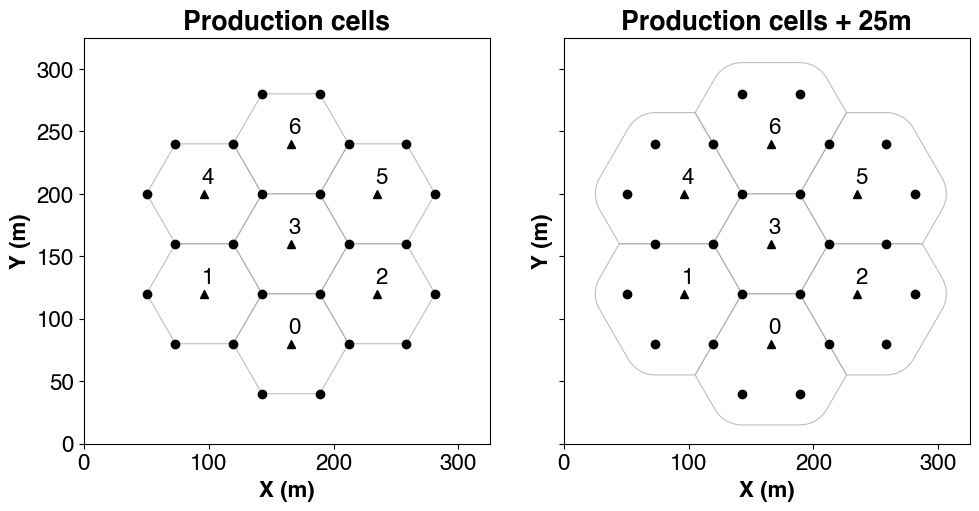

In [32]:
plotter_wf = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2"],
            ],
            sharey=True,
            sharex=True,
        )
    },
)


# 1) Add wells
def add_wells_to_axes(axes: Sequence[Axes]) -> None:
    for ax in axes:
        # Add injectors
        for i, j in inj_grid_coordinates:
            ax.plot(i, j, "ko")
        # Add producers
        for i, j in prod_grid_coordinates:
            ax.plot(i, j, "k^" if is_gray_scale else "ro")


add_wells_to_axes(plotter_wf.axes)

# 2) Add normal cells
ax = plotter_wf.ax_dict["ax1-1"]
patches = []
for polygon in prod_cell_polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.75)
p.set_facecolors("none")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
ax.add_collection(p)
ax.set_title("Production cells", fontweight="bold")

# 3) Add extended cells -> using shapely
ax = plotter_wf.ax_dict["ax1-2"]
patches = []
for _polygon_ext in prod_cell_polygons_ext25m:
    # Add the polygon to the collection of patches
    patches.append(Polygon(_polygon_ext, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.75)
p.set_facecolors("none")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
ax.add_collection(p)
ax.set_title("Production cells + 25m", fontweight="bold")

for ax in plotter_wf.ax_dict.values():
    for i, prod_coords in enumerate(prod_grid_coordinates):
        ax.text(prod_coords[0] - 2, prod_coords[1] + 8, i)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_xlabel("X (m)", fontweight="bold")
    ax.set_ylabel("Y (m)", fontweight="bold")

fname = "7_cells_wellfield"
for format in ["png", "pdf", "svg"]:
    plotter_wf.fig.savefig(
        str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
    )

In [33]:
cells_ids = np.arange(len(prod_cell_polygons)) + 1

prod_cells_selection_array = get_polygon_selection_with_dilation_2d(
    prod_cell_polygons, grid
)
# prod_cells_selection_ext25m_array = get_polygon_selection_with_dilation_2d(prod_cell_polygons_ext25m, grid, selection=prod_cells_selection_array)
prod_cells_selection_ext25m_array = create_selections_array_2d(
    prod_cell_polygons_ext25m, cells_ids, grid
)

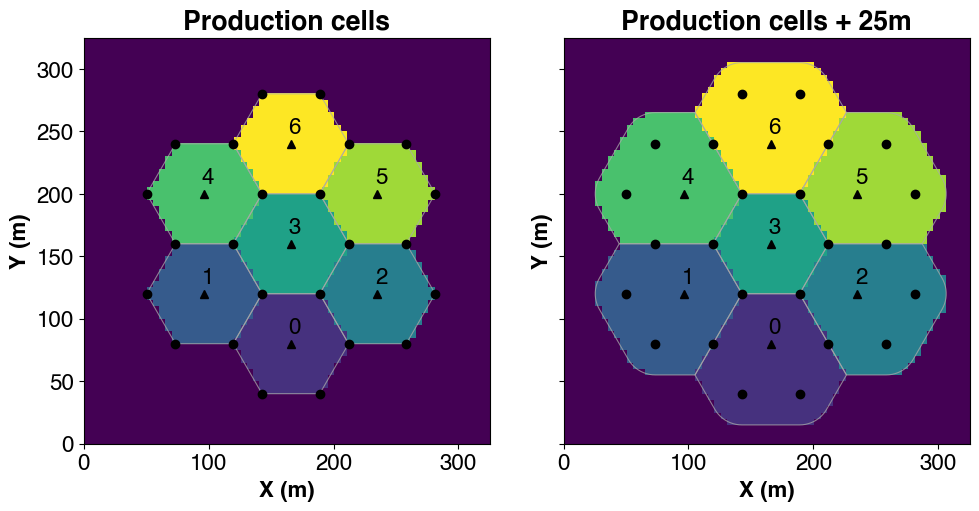

In [34]:
plotter_wf.axes[0].imshow(
    prod_cells_selection_array.T, origin="lower", extent=[0.0, nx * dx, 0.0, ny * dy]
)
plotter_wf.axes[1].imshow(
    prod_cells_selection_ext25m_array.T,
    origin="lower",
    extent=[0.0, nx * dx, 0.0, ny * dy],
)

fname = "7_cells_wellfield_with_selections"
for format in ["png", "pdf", "svg"]:
    plotter_wf.fig.savefig(
        str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
    )
plotter_wf.fig

- The model errors will be estimated at three levels -> Full grid, extended selection and within the production cells. 

In [35]:
prod_grid_coordinates[0]

(165.85680518387326, 80.0480947161671)

- Make some selection

In [36]:
mpl_polygons = []
shapely_polygons = []

# Iterate the prod_cell_polygons to create matplotlib and shapely polygon instances
for polygon in prod_cell_polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    mpl_polygons.append(Polygon(xy, closed=True, facecolor=None))
    shapely_polygons.append(ShapelyPolygon(xy))

# Generate well field prod_cell_polygons
full_box = ShapelyBox(0.0, 0.0, nx * dx, ny * dy)  # polygon covering all the grid
inner_area = cascaded_union(shapely_polygons)  # polygon covering the well-field area
buffered_inner_area = inner_area.buffer(10.0)  # add a 10 m buffer around the
buffered_external_area = full_box.difference(
    buffered_inner_area
)  # ouside well-field area

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [37]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it
- For now steady state

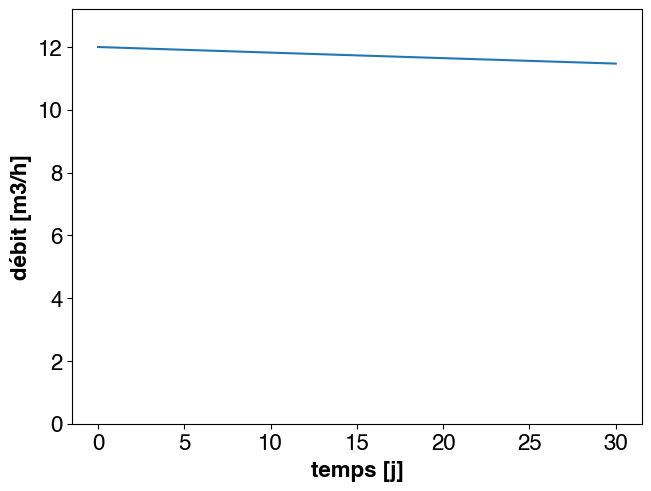

In [38]:
plotter = ngp.NestedGridPlotter()
init_prod_flowrates = 12.0  # m3/s
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.0015, duration_in_days + 1, dt=1.0
)  # m3/h

# cleaning actions
flowrates[300:] *= 1.5

# At 350 -> reset the flowrates

time_in_days = np.arange(duration_in_days + 1)
# plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
# plt.ylim(0.0, init_prod_flowrates * 1.1)
ax = plotter.axes[0]
ax.plot(np.arange(duration_in_days + 1), flowrates)
ax.set_ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    ax.set_ylabel("flowrates [m3/h]", fontweight="bold")
    ax.set_xlabel("time [d]", fontweight="bold")
else:
    ax.set_ylabel("débit [m3/h]", fontweight="bold")
    ax.set_xlabel("temps [j]", fontweight="bold")

fname = "flowrates_decrease"
for format in ["png", "pdf", "svg"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Injected reageant varying over time

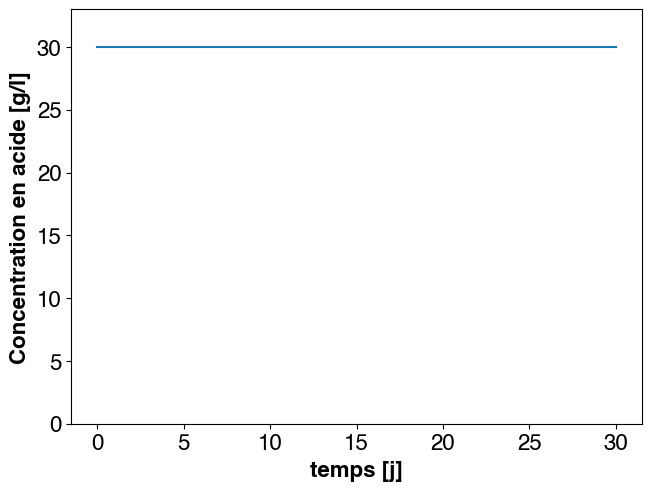

In [39]:
conv_h2so4_conc: float = 98.078


def conc_h2so4_molpl_to_gpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x * conv_h2so4_conc)


def conc_h2so4_gpl_to_molpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x / conv_h2so4_conc)


_inj_conc = np.zeros(duration_in_days + 1)
_inj_conc[0:40] = conc_h2so4_gpl_to_molpl(30.0)  # 20 g/l
_inj_conc[40:60] = conc_h2so4_gpl_to_molpl(10.0)  # 10 g/l
_inj_conc[60:100] = conc_h2so4_gpl_to_molpl(6.0)  # 6 g/l
# _inj_conc[70:80] = conc_h2so4_gpl_to_molpl(20.0)  # 6 g/l
# _inj_conc[80:100] = conc_h2so4_gpl_to_molpl(0.0)  # 6 g/l
_inj_conc[100:120] = conc_h2so4_gpl_to_molpl(20.0)  # 20 g/l
_inj_conc[120:160] = conc_h2so4_gpl_to_molpl(5.0)  # 6 g/l
_inj_conc[180:200] = conc_h2so4_gpl_to_molpl(15.0)  # 6 g/l
_inj_conc[200:] = conc_h2so4_gpl_to_molpl(6.0)  # 4 g/l
_inj_conc[300:] = conc_h2so4_gpl_to_molpl(20.0)  # 15 g/l
_inj_conc[320:] = conc_h2so4_gpl_to_molpl(10.0)  # 4 g/l
_inj_conc[350:] = conc_h2so4_gpl_to_molpl(5.0)  # 4 g/l
time_in_days = np.arange(duration_in_days + 1)

plotter = ngp.NestedGridPlotter()
ax = plotter.axes[0]
# plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
ax.set_ylim(0.0, np.max(conc_h2so4_molpl_to_gpl(_inj_conc)) * 1.1)

ax.plot(np.arange(duration_in_days + 1), conc_h2so4_molpl_to_gpl(_inj_conc))
# plt.ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    ax.set_ylabel("Injected acid conc [g/l]", fontweight="bold")
    ax.set_xlabel("time [d]", fontweight="bold")
else:
    ax.set_ylabel("Concentration en acide [g/l]", fontweight="bold")
    ax.set_xlabel("temps [j]", fontweight="bold")

fname = "acid_conc"
for format in ["png", "pdf", "svg"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

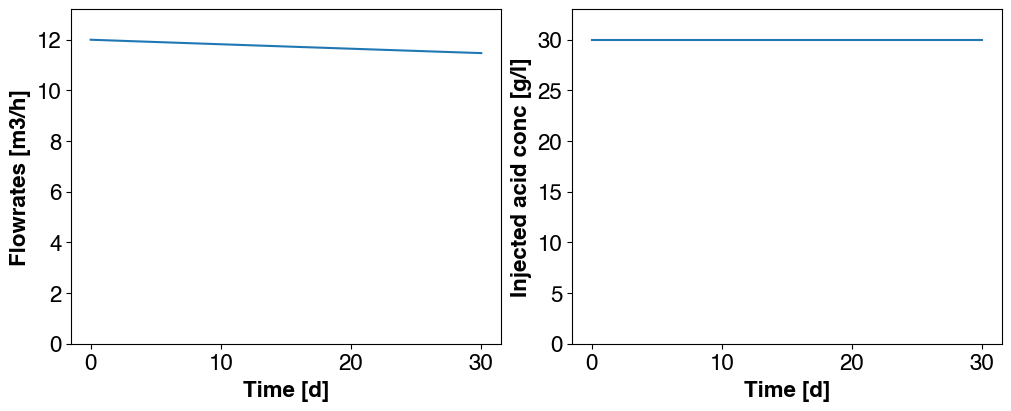

In [40]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4.0)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=False, sharex=True)
    },
)
# 1) Flowrates
ax1 = plotter.get_axis("ax1-1")
ax1.plot(np.arange(duration_in_days + 1), flowrates)
ax1.set_ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    ax1.set_ylabel("Débit [m3/h]", fontweight="bold")
    ax1.set_xlabel("Temps [j]", fontweight="bold")
else:
    ax1.set_ylabel("Flowrates [m3/h]", fontweight="bold")
    ax1.set_xlabel("Time [d]", fontweight="bold")

# 2) Acid
ax2 = plotter.get_axis("ax1-2")
ax2.set_ylim(0.0, np.max(conc_h2so4_molpl_to_gpl(_inj_conc)) * 1.1)
ax2.plot(np.arange(duration_in_days + 1), conc_h2so4_molpl_to_gpl(_inj_conc))
# plt.ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    ax2.set_ylabel("Concentration en acide [g/l]", fontweight="bold")
    ax2.set_xlabel("Temps [j]", fontweight="bold")
else:
    ax2.set_ylabel("Injected acid conc [g/l]", fontweight="bold")
    ax2.set_xlabel("Time [d]", fontweight="bold")

fname = "flowrates_and_acid_conc"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Mineral grade: reference vs estimated

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [41]:
rock_density = 1.63
conv_u_grade: NDArrayFloat = np.array(
    [1.023 * rock_density / (238.0 * porosity * 1000)]
)

- Conversion factor for uranium from mol/l to mg/l

In [42]:
conv_u_conc: float = (270.03 - 0.0016 * 2) * 1e3

- Functions to perform the conversions

In [43]:
def grade_ppm_to_mol_per_kg(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return x * conv_u_grade


def grade_mol_per_kg_to_ppm(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return x / conv_u_grade


def grade_mol_per_kg_to_ppm_1st_derivative(
    x: Union[NDArrayFloat, float],
) -> NDArrayFloat:
    return 1 / conv_u_grade


pcd = preconditioner = dminv.LinearTransform(
    slope=float(1.0 / conv_u_grade[0]), y_intercept=0.0
)


def conc_molpl_to_mgpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x * conv_u_conc)


def conc_mgpl_to_molpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x / conv_u_conc)

In [44]:
conc_h2so4_molpl_to_gpl(2e-1)

array(19.6156)

- Using the SPDE approach, generate a random field

In [45]:
len_scale = 20.0  # m
kappa = 1 / len_scale
alpha = 1.0

mean = 0.0  # trend of the field
std = 200.0  # standard deviation of the field

# Create a precison matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
cholQ_ref = cholesky(Q_ref)
# Non conditonal simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T

bounds_clipper = dminv.BoundsClipper(1.0, 2000.0)  # bounds = [1, 2000] ppm

reference_grade_ppm = bounds_clipper.backtransform(simu_ + mean)

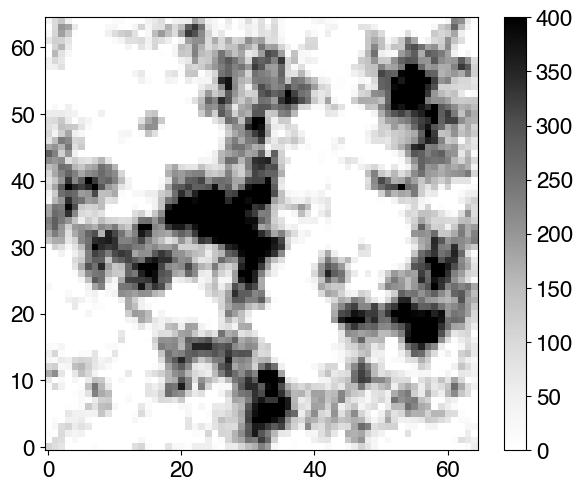

In [46]:
plt.imshow(
    reference_grade_ppm.T,
    origin="lower",
    cmap=jet_cmap,
    aspect="equal",
    vmin=0.0,
    vmax=400,
)
plt.colorbar()

- Simulation du krr

In [47]:
len_scale_krr = 20.0  # m
kappa_krr = 1 / len_scale
alpha_krr = 2.0

mean_krr = 1.3  # trend of the field
std_krr = 0.5  # standard deviation of the field

# Create a precison matrix
Q_krr = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa_krr, alpha_krr, spatial_dim=2, sigma=std_krr
)
cholQ_krr = cholesky(Q_krr)
# Non conditonal simulation -> change the random state to obtain a different field
simu_krr = spde.simu_nc(cholQ_krr, random_state=2026).reshape(ny, nx).T
krr = np.abs(simu_krr + mean_krr)

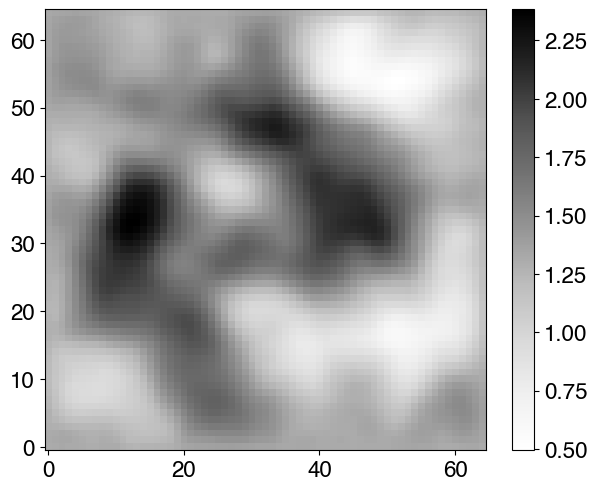

In [48]:
plt.imshow(
    krr.T,
    origin="lower",
    cmap=jet_cmap,
    aspect="equal",
)
plt.colorbar()

- Select some points from this field (drilling places) -> green dots on the map

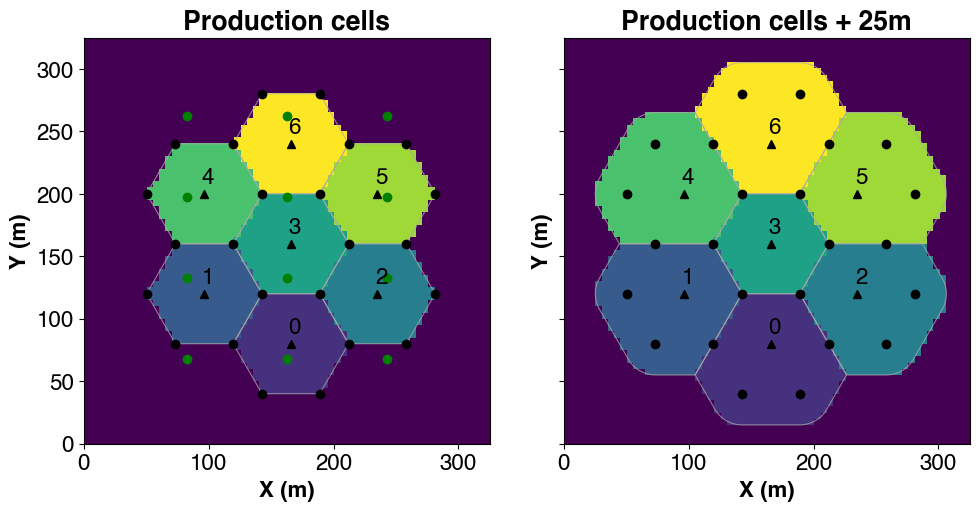

In [49]:
_ix = np.array([int(nx / 4), 2 * int(nx / 4), 3 * int(nx / 4)])
_iy = np.array([int(ny / 5), 2 * int(ny / 5), 3 * int(ny / 5), 4 * int(ny / 5)])

dat_coords = np.array(np.meshgrid(_ix, _iy)).reshape(2, -1)
# Get the node numbers
dat_nn: NDArrayInt = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])
dat_val = reference_grade_ppm.ravel("F")[dat_nn]

for i, j in dat_coords.T:
    plotter_wf.ax_dict["ax1-1"].plot((i + 0.5) * dx, (j + 0.5) * dy, "go")

plotter_wf.fig

- Generate 3 conditional simulations with more or less error on the known data with a varigram which is not exactly correct + one constant field (witness case)

In [50]:
# Generate new points with error -> systematic bias 200 ppm + some variance on the
# measures (10 ppm)
measure_era = dat_val / krr.ravel("F")[dat_nn]
# we cannot have negative measure so we clip
measure_era_noisy = np.clip(
    measure_era + (np.random.default_rng(2048).normal(scale=10, size=dat_val.size)),
    a_min=1.0,
    a_max=10000.0,
)

# ) + 100 * np.random.default_rng(2025).normal(
#     scale=1.0, size=dat_val.size
# )) / 2
estimated_krr = 0.65
dat_val_wrong = measure_era_noisy * estimated_krr

# Condition with the exact data -> we assume the krr variability known
# So we perform uncertainty propagation
_uq = np.std(
    measure_era_noisy
    * np.random.normal(loc=estimated_krr, scale=std_krr, size=(10000, dat_val.size)),
    axis=0,
)
dat_var_init = _uq**2

# Compute the average on the data points (trend)
estimated_mean = np.average(dat_val_wrong)

if is_use_exact_std:
    estimated_std = std
else:
    estimated_std = float(np.std(dat_val_wrong))

alpha = 1

# Create a precison matrix
Q_init = spde.get_precision_matrix(
    nx, ny, 1, dx, dy, 1.0, kappa, alpha, spatial_dim=2, sigma=estimated_std
)
Q_init_c = spde.condition_precision_matrix(Q_init, dat_nn, dat_var_init)

# Decompose with cholesky
cholQ_init = cholesky(Q_init)
cholQ_init_c = cholesky(Q_init_c)

estimate_grade_simu_ppm = bounds_clipper.backtransform(
    spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_val_wrong - estimated_mean,
        dat_nn,
        dat_var_init,
        random_state=2063,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

estimate_grade_simu_ppm = bounds_clipper.backtransform(
    spde.kriging(
        Q_init_c,
        dat_val_wrong - estimated_mean,
        dat_nn,
        cholQ_init_c,
        dat_var_init,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

## Build a parametrization

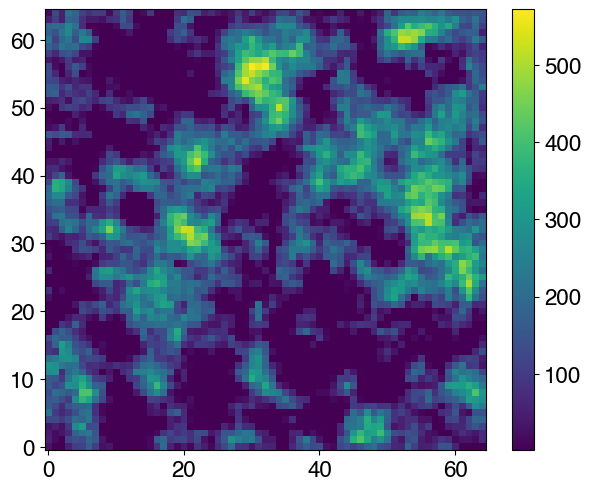

In [51]:
ne = 100
gdpcs = dminv.GDPCS(
    ne,
    Q_nc=Q_init,
    Q_c=Q_init_c,
    estimated_mean=float(estimated_mean),
    dat_nn=dat_nn,
    dat_val=dat_val_wrong,
    dat_var=dat_var_init,
    cholQ_nc=cholQ_init,
    cholQ_c=cholQ_init_c,
    random_state=12873,
    is_update_mean=True,
)

# We apply three successive preconditionning:
# 1) A first one to convert mol/kg to ppm
# 2) A second one to ensure positive values when backconditioning
# 3) A third one to convert ppm to white noise linear combinaison weights through the
# gradual deformation + SPDE approach
pcd = dminv.ChainedTransforms(
    [
        dminv.LinearTransform(slope=1 / conv_u_grade, y_intercept=0.0),
        dminv.BoundsClipper(1.0, 2000.0),  # bounds = [1, 2000] ppm
        # dminv.InvAbsTransform(),
        gdpcs,
    ]
)
estimate_grade_simu_ppm = grade_mol_per_kg_to_ppm(
    pcd.backtransform(np.hstack([gdpcs.theta, gdpcs.estimated_mean]).ravel()).reshape(
        nx, ny, order="F"
    )
)
plt.imshow(estimate_grade_simu_ppm, origin="lower")
plt.colorbar()

In [52]:
grade_ppm_to_mol_per_kg(1)

array([3.04620022e-05])

- Plot the tonnages per mesh

In [53]:
def get_sel_u_tonnages(
    u_field_grades: NDArrayFloat,
    selection_array: NDArrayInt,
    geom: dmfwd.Geometry,
) -> NDArrayFloat:
    """Return the tonnages in t under the given technological cell.

    Parameters
    ----------
    u_field_grades : NDArrayFloat
        Uraninite grades field in ppm. 2D Array.
    dx : float
        X dimension of one mesh [m].
    dy : float
        Y dimension of one mesh [m].
    dz : float
        Z dimension of one mesh [m].
    mask: NDArrayFloat
        Mask to apply before doing the selection.
    Returns
    -------
    float
        The associated uranium tonnages in t.
    """

    # Conversion factor to go from a number of ppm per unit of volume to a mass in t (all cells are the same)
    conv_factor = geom.mesh_volume * rock_density * 1e-6
    tonnages_list = []
    for sel_id in np.unique(selection_array):
        tonnages_list.append(
            float(u_field_grades[selection_array == sel_id].sum() * conv_factor)
        )
    return np.array(tonnages_list)

- Compute the reserve associated to the cells in t
- Need to transpose for the display

In [54]:
reference_tonnages = get_sel_u_tonnages(
    reference_grade_ppm, prod_cells_selection_array, geom=geometry
)
estimated_tonnages_simu = get_sel_u_tonnages(
    estimate_grade_simu_ppm, prod_cells_selection_array, geom=geometry
)

reference_tonnages_ext25m = get_sel_u_tonnages(
    reference_grade_ppm, prod_cells_selection_ext25m_array, geom=geometry
)
estimated_tonnages_simu_ext25m = get_sel_u_tonnages(
    estimate_grade_simu_ppm, prod_cells_selection_ext25m_array, geom=geometry
)

- Compute deviations

In [55]:
initial_u_dev_simu_total = np.sum(estimated_tonnages_simu) - np.sum(reference_tonnages)
initial_u_dev_simu_total_frac = initial_u_dev_simu_total / np.sum(reference_tonnages)

initial_u_dev_simu_cells = np.sum(estimated_tonnages_simu[1:]) - np.sum(
    reference_tonnages[1:]
)
initial_u_dev_simu_cells_frac = initial_u_dev_simu_cells / np.sum(
    reference_tonnages[1:]
)

initial_u_dev_simu_cells_ext25m = np.sum(estimated_tonnages_simu_ext25m[1:]) - np.sum(
    reference_tonnages_ext25m[1:]
)
initial_u_dev_simu_cells_ext25m_frac = initial_u_dev_simu_cells_ext25m / np.sum(
    reference_tonnages_ext25m[1:]
)


logging.info(
    f"initial_U_dev_simu_total = {initial_u_dev_simu_total:.2f} t ({initial_u_dev_simu_total_frac * 100:.2f}%)"
)
logging.info(
    f"initial_U_dev_simu_cells = {initial_u_dev_simu_cells:.2f} t ({initial_u_dev_simu_cells_frac * 100:.2f}%)"
)
logging.info(
    f"initial_U_dev_simu_extended_cells = {initial_u_dev_simu_cells_ext25m:.2f} t ({initial_u_dev_simu_cells_ext25m_frac * 100:.2f}%)"
)

INFO:root:initial_U_dev_simu_total = -3.95 t (-3.76%)
INFO:root:initial_U_dev_simu_cells = -7.72 t (-16.60%)
INFO:root:initial_U_dev_simu_extended_cells = -8.82 t (-12.06%)


- Some utils for plots

In [56]:
# 2) Plot the tonnages
def add_tonnages_to_axis(
    ax: Axes,
    tonnages: NDArrayFloat,
    ref_tonnages: NDArrayFloat,
    cmap: mpl.colors.Colormap,
    _polygons: Sequence[NDArrayFloat],
) -> PatchCollection:
    patches = []
    for i, (sel_polygon, prod_coords) in enumerate(
        zip(_polygons, prod_grid_coordinates)
    ):
        # Add the polygon to the collection of patches
        xy = np.array(sel_polygon)
        patches.append(Polygon(xy, closed=True, facecolor=None))

        centroid = (prod_coords[0] + 6, prod_coords[1] + 10)

        ax.text(
            *centroid,
            f"{tonnages[i]:.2f} t",
            fontsize=10,
            fontweight="bold",
            ha="center",
        )

        # Plot the number of the polygon
    patch_collection = PatchCollection(patches, alpha=0.5, cmap=cmap)
    # patch_collection.set_facecolors("white")
    patch_collection.set_edgecolors("black")
    patch_collection.set_linewidth(0.6)
    patch_collection.set_linestyle("-")
    patch_collection.set_array(np.array(tonnages, dtype=float))
    patch_collection.set_clim(int(np.min(ref_tonnages)), int(np.max(ref_tonnages) + 1))
    ax.add_collection(patch_collection)
    return patch_collection


def plot_tonnages(
    _fig: mpl.figure.Figure,
    axes: Sequence[Axes],
    data: Sequence[NDArrayFloat],
    ref_axis: int = 0,
    is_use_extended_cells: bool = False,
) -> None:
    # Add the wells
    add_wells_to_axes(axes)

    # get the reference tonnage
    # [1:] because the first element is for the outter selection (outside the block)
    if is_use_extended_cells:
        _ref_tonnages = reference_tonnages_ext25m[1:]
        _polygons = prod_cell_polygons_ext25m
        _sel_array = prod_cells_selection_ext25m_array
    else:
        _ref_tonnages = reference_tonnages[1:]
        _polygons = prod_cell_polygons
        _sel_array = prod_cells_selection_array

    # Plot the cells
    for _n, (ax, u_field_ppm) in enumerate(zip(axes, data)):
        tonnages = get_sel_u_tonnages(u_field_ppm, _sel_array, geometry)[1:]
        patch_collection = add_tonnages_to_axis(
            ax, tonnages, _ref_tonnages, jet_cmap, _polygons
        )

        # Add the tonnages
        tmp = ax.set_title(f"{np.sum(tonnages):.2f} t", fontweight="bold")

        if _n != ref_axis:
            # Absolute deviation
            ton_diff_abs = np.sum(tonnages) - np.sum(_ref_tonnages)
            # Relative deviation
            ton_diff_rel = ton_diff_abs / np.sum(_ref_tonnages)

            pos = tmp.get_position()
            txt = ax.text(
                pos[0] + 0.2,
                pos[1] + 0.04,
                f"({ton_diff_rel * 100:+.2f}%)",
                fontweight="bold",
                transform=ax.transAxes,
                color=(
                    "k" if is_gray_scale else "r" if np.abs(ton_diff_rel) > 0.1 else "g"
                ),
            )

    # Add a common colorbar
    cbar = _fig.colorbar(
        patch_collection,
        ax=axes,
        orientation="vertical",
        fraction=0.1,
        format="%2.f",
        pad=0.01,
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Uranium [t]", rotation=270)


def plot_tonnages_deviations(
    _fig: mpl.figure.Figure,
    axes: Sequence[Axes],
    data: Sequence[NDArrayFloat],
    ref_axis: int = 0,
    is_use_extended_cells: bool = False,
) -> None:
    # Add the wells
    add_wells_to_axes(axes)

    # get the reference tonnage
    # [1:] because the first element is for the outter selection (outside the block)
    if is_use_extended_cells:
        _ref_tonnages = reference_tonnages_ext25m[1:]
        _polygons = prod_cell_polygons_ext25m
        _sel_array = prod_cells_selection_ext25m_array
    else:
        _ref_tonnages = reference_tonnages[1:]
        _polygons = prod_cell_polygons
        _sel_array = prod_cells_selection_array

    # Plot the cells
    for _n, (ax, u_field_ppm) in enumerate(zip(axes, data)):
        _tonnages_dev = get_sel_u_tonnages(
            u_field_ppm - reference_grade_ppm, _sel_array, geometry
        )[1:]
        patch_collection = add_tonnages_to_axis(
            ax, _tonnages_dev, np.array([-2, 1]), bwr_cmap, _polygons
        )

        # Add the tonnages
        tmp = ax.set_title(
            f"\u00b1{np.mean(np.abs(_tonnages_dev)):.2f} t", fontweight="bold"
        )

        if _n != ref_axis:
            # Relative deviation
            ton_diff_rel = np.mean(np.abs(_tonnages_dev / _ref_tonnages))
            pos = tmp.get_position()
            txt = ax.text(
                pos[0] + 0.2,
                pos[1] + 0.04,
                f"(\u00b1{ton_diff_rel * 100:.2f}%)",
                fontweight="bold",
                transform=ax.transAxes,
                color=(
                    "k" if is_gray_scale else "r" if np.abs(ton_diff_rel) > 0.1 else "g"
                ),
            )

    # Add a common colorbar
    # Add a common colorbar
    cbar = _fig.colorbar(
        patch_collection,
        ax=axes,
        orientation="vertical",
        fraction=0.1,
        format="%2.f",
        pad=0.01,
    )
    cbar.ax.get_yaxis().labelpad = 20
    if language == Lg.ENGLISH:
        cbar_title = "Uranium deviation [t]"
    else:
        cbar_title = "Différence [t]"
    cbar.ax.set_ylabel(cbar_title, rotation=270)

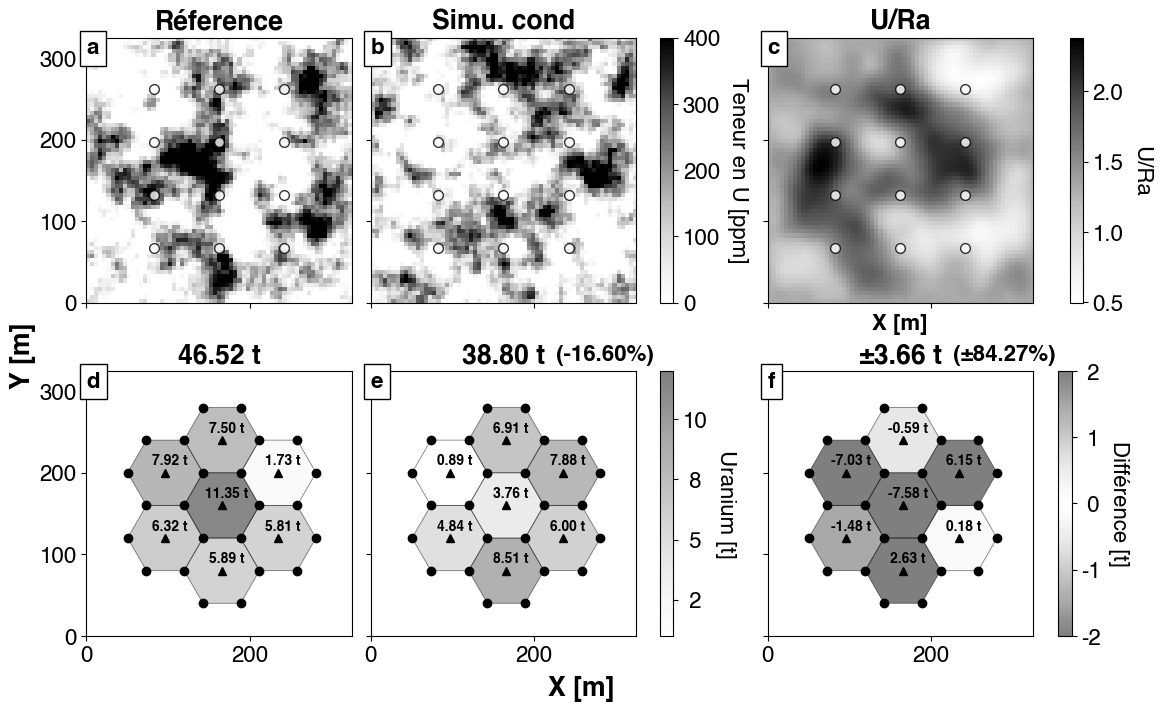

In [57]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11.5, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax2-1", "ax3-1"], ["ax1-2", "ax2-2", "ax3-2"]],
            sharey=True,
            sharex=True,
        ),
    },
)

# 1) Plot the grades
if language == Lg.ENGLISH:
    labels = ["Reference", "Simu. cond"]
    cbar_title = "Uranium grade [ppm]"
else:
    labels = ["Réference", "Simu. cond"]
    cbar_title = "Teneur en U [ppm]"

cbar_up = ngp.multi_imshow(
    axes=plotter.axes[:2],
    fig=plotter.fig,
    data={
        labels[0]: reference_grade_ppm,
        labels[1]: estimate_grade_simu_ppm,
    },
    cbar_title=cbar_title,
    imshow_kwargs={
        "cmap": jet_cmap,
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400.0,
        "aspect": "equal",
    },
    cbar_kwargs={"pad": 0.01},
)

# 2) Plot the tonnages
plot_tonnages(
    plotter.fig,
    [plotter.axes[3], plotter.axes[4]],
    (
        reference_grade_ppm,
        estimate_grade_simu_ppm,
    ),
    is_use_extended_cells=False,
)

# 3) Plot the U/Ra
cbar = ngp.multi_imshow(
    axes=plotter.axes[2:3],
    fig=plotter.fig,
    data={
        "U/Ra": krr,
    },
    cbar_title="U/Ra",
    imshow_kwargs={
        "cmap": jet_cmap,
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    cbar_kwargs={"shrink": 1.0},
    xlabel="X [m]",
    # ylabel="Y [m]",
)

# 4) Plot the tonnages deviation for the last frame
plot_tonnages_deviations(
    plotter.fig,
    plotter.axes[-1:],
    (estimate_grade_simu_ppm,),
    is_use_extended_cells=False,
    ref_axis=-1,
)

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Y [m]", fontweight="bold")


def add_sampling_points(axes: List[Axes]) -> None:
    for ax in axes:
        # plot the sampling points here
        ax.plot(
            (dat_coords[0] + 0.5) * dx,
            (dat_coords[1] + 0.5) * dy,
            linestyle="None",
            marker="o",
            markersize=7,
            color="k",
            markerfacecolor="white",
            alpha=0.8,
        )


add_sampling_points(plotter.axes[:3])

ngp.add_letter_to_frames(plotter.axes)

fname = "tonnages_+_grades_per_cells_+_URa"
for format in ["png", "pdf", "svg"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the estimated field variance

Text(0, 0.5, 'Y [m]')

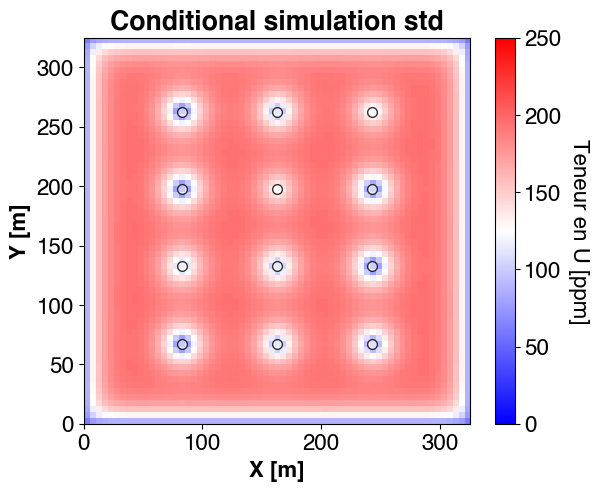

In [38]:
estimated_field_var_ppm = spde.get_variance(Q_init_c, cholQ_init_c).reshape(
    nx, ny, order="F"
)
plotter = ngp.NestedGridPlotter()
ax = plotter.axes[0]
ngp.multi_imshow(
    axes=plotter.axes[:1],
    fig=plotter.fig,
    data={
        "Conditional simulation std": np.sqrt(estimated_field_var_ppm),
    },
    cbar_title=cbar_title,
    imshow_kwargs={
        # "cmap": jet_cmap,
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 250.0,
        "aspect": "equal",
    },
    cbar_kwargs={"pad": 0.05},
)
add_sampling_points(plotter.axes[:1])
plotter.axes[0].set_xlabel("X [m]", fontweight="bold")
plotter.axes[0].set_ylabel("Y [m]", fontweight="bold")

## Forward problem in demonstrator

In [39]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_seconds,
    dt_init=dt_init,
    dt_min=dt_min,
    dt_max=dt_max,
    courant_factor=courant_factor,
)
fl_params = dmfwd.FlowParameters(
    permeability=permeability,
    storage_coefficient=storage_coefficient,
    regime=dmfwd.FlowRegime.TRANSIENT,
    tolerance=1e-10,
)
tr_params = dmfwd.TransportParameters(
    diffusion=diffusion_coef,
    porosity=porosity,
    crank_nicolson_diffusion=1.0,
    crank_nicolson_advection=0.5,
    tolerance=1e-12,
    fpi_eps=1e-5,
    is_numerical_acceleration=True,
)
gch_params = dmfwd.GeochemicalParameters(
    conc=c0, grade=M0, kv=kv, As=As, Ks=Ks, stocoef=200.0
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Add source and sink terms

In [40]:
flw_times_in_s = np.arange(duration_in_days + 1) * 3600 * 24.0
prod_flw = -flowrates / 3600  # m3/h to m3/s
# times = np.arange(stop=nt + 1, start=0) * dt

for count_prod, (ix, iy) in enumerate(prod_grid_indices):
    name = f"producer_{ix}_{iy}"

    sink_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_node_number(ix, nx, iy)]),
        times=flw_times_in_s,
        flowrates=prod_flw,
        concentrations=np.zeros((*prod_flw.shape, 2)),
    )
    base_model.add_src_term(sink_term)

for count_inj, (ix, iy) in enumerate(inj_grid_indices):
    x, y = inj_grid_coordinates[count_inj]
    name = f"injector_{ix}_{iy}"

    nb_prod_well_linked = 0
    # Find the number of producers that the injector is linked with
    for xp, yp in prod_grid_coordinates:
        # we take 20% margin on the cell radius
        if np.sqrt((x - xp) ** 2 + (y - yp) ** 2) < cell_radius * 1.2:
            nb_prod_well_linked += 1

    # NOTE: need to inject a non null quantity to avoid numerical issues
    inj_conc = np.zeros((*prod_flw.shape, 2))
    inj_conc[:, 1] = _inj_conc
    inj_conc[inj_conc < 0] = 1e-10

    source_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_node_number(ix, nx, iy)]),
        times=flw_times_in_s,
        flowrates=-prod_flw
        / 6.0
        * nb_prod_well_linked,  # /6.0 because of hexagonal cells
        concentrations=inj_conc,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Check the hydraulic balance

In [41]:
total_prod_flow = 0
total_inj_flow = 0

for source_term in base_model.source_terms:
    _dt = np.diff(flw_times_in_s)  # timesteps in s
    total_inj_flow += np.sum(
        np.where(source_term.flowrates > 0, source_term.flowrates, 0.0)[1:] * _dt
    )
    total_prod_flow += np.sum(
        np.where(source_term.flowrates < 0, -source_term.flowrates, 0.0)[1:] * _dt
    )

logging.info(f"total_prod_flow = {total_prod_flow} m3")
logging.info(f"total_inj_flow = {total_inj_flow} m3")

# This test should fail if there is any issue !
assert np.round(total_prod_flow, 4) == np.round(total_inj_flow, 4)

INFO:root:total_prod_flow = 59095.04096663563 m3
INFO:root:total_inj_flow = 59095.04096663563 m3


In [42]:
source_term.times.size

31

- Add boundary conditions

In [43]:
# # west
# base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
# # est
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
# )
# # south
# base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(None), slice(0, 1))))
# # north
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(None), slice(nx - 1, nx)))
# )

In [44]:
model_reference = copy.deepcopy(base_model)
model_estimate = copy.deepcopy(base_model)

# Exact initial uranium grade
model_reference.tr_model.set_initial_grade(grade_ppm_to_mol_per_kg(reference_grade_ppm))
# Estimated initial uranim grade
model_estimate.tr_model.set_initial_grade(
    grade_ppm_to_mol_per_kg(estimate_grade_simu_ppm)
)

- Run the models

In [45]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve(is_verbose=False)

In [46]:
solver_estimate_simu = dmfwd.ForwardSolver(model_estimate)
solver_estimate_simu.solve(is_verbose=False)

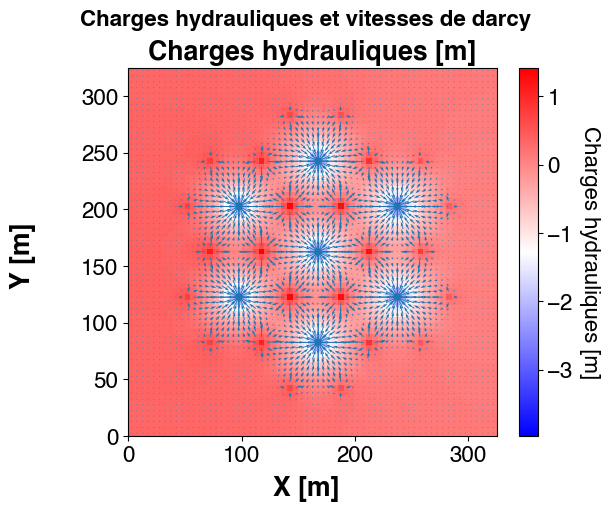

In [47]:
time_index_1 = 10
time_index_2 = 20

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    # subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
    },
)

if language == Lg.ENGLISH:
    label = "Hydraulic head [m]"
else:
    label = "Charges hydrauliques [m]"

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        label: model_estimate.fl_model.head[:, :, time_index_1],
        #         "Head [m] 2": model_estimate.fl_model.head[:, :, time_index_2],
    },
    cbar_title=label,
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

for ax, time_index in zip(plotter.axes, [time_index_1, time_index_2]):
    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)
    ax.quiver(
        X,
        Y,
        model_estimate.fl_model.u_darcy_x_center[:, :, time_index],
        model_estimate.fl_model.u_darcy_y_center[:, :, time_index],
        color="C0",
        scale_units="xy",
    )

# plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
# plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

if language == Lg.ENGLISH:
    title = "Hydraulic head and darcy velocities"
else:
    title = "Charges hydrauliques et vitesses de darcy"
plotter.subfigs["fig0"].suptitle(title, fontweight="bold", fontsize=16)
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y [m]", fontweight="bold")

fname = "heads_and_velocities"
for format in ["png", "pdf", "svg"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the concentration evolution

## Observations and associated uncertainties

- We select only 10% of the data points available to get something more realistic

In [48]:
freq_measure_in_days = 6  # one measure every four days
n_sampled_days = (
    min(duration_in_days_inv, model_reference.time_params.time_elapsed / 24 / 3600)
    / freq_measure_in_days
)

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_days
obs_times_in_d = obs_times_in_s / 3600 / 24
obs_times_in_s

array([      0.,  518400., 1036800., 1555200., 2073600.])

In [49]:
np.count_nonzero(model_estimate.tr_model.conc2 < 0.0)

0

- Create a function to add some noise to the observations

In [50]:
noise_std: float = conc_mgpl_to_molpl(2.0)  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise((len(prod_grid_indices), obs_times_in_s.size))

- Noise in mg/l

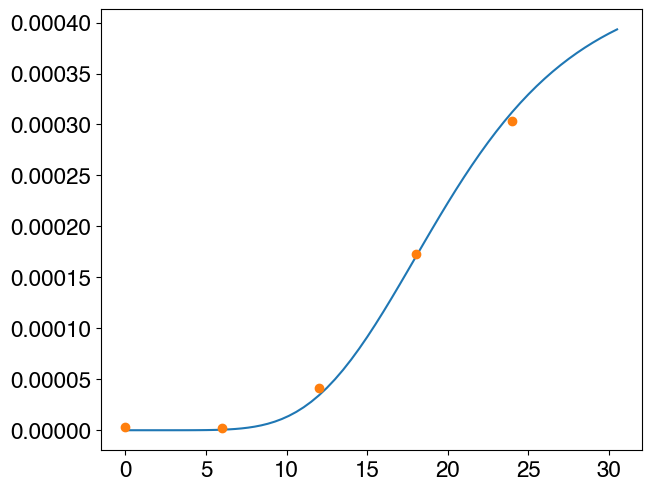

In [51]:
simu_times_ref_in_s = model_reference.time_params.times
simu_times_ref_in_d = simu_times_ref_in_s / 3600 / 24

simu_times_est_in_s = model_estimate.time_params.times
simu_times_est_in_d = simu_times_est_in_s / 3600 / 24

obs_values = np.zeros((len(prod_grid_indices), obs_times_in_s.size))

for count, (ix, iy) in enumerate(prod_grid_indices):
    # interpolate the values
    obs_values[count] = np.abs(
        interp1d(
            simu_times_ref_in_s, model_reference.tr_model.conc[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise[count, :]
    )

count = 2

ix, iy = prod_grid_indices[count]
plt.plot(simu_times_ref_in_d, model_reference.tr_model.conc[ix, iy, :])
plt.plot(
    obs_times_in_d,
    obs_values[count],
    marker="o",
    linestyle="none",
)

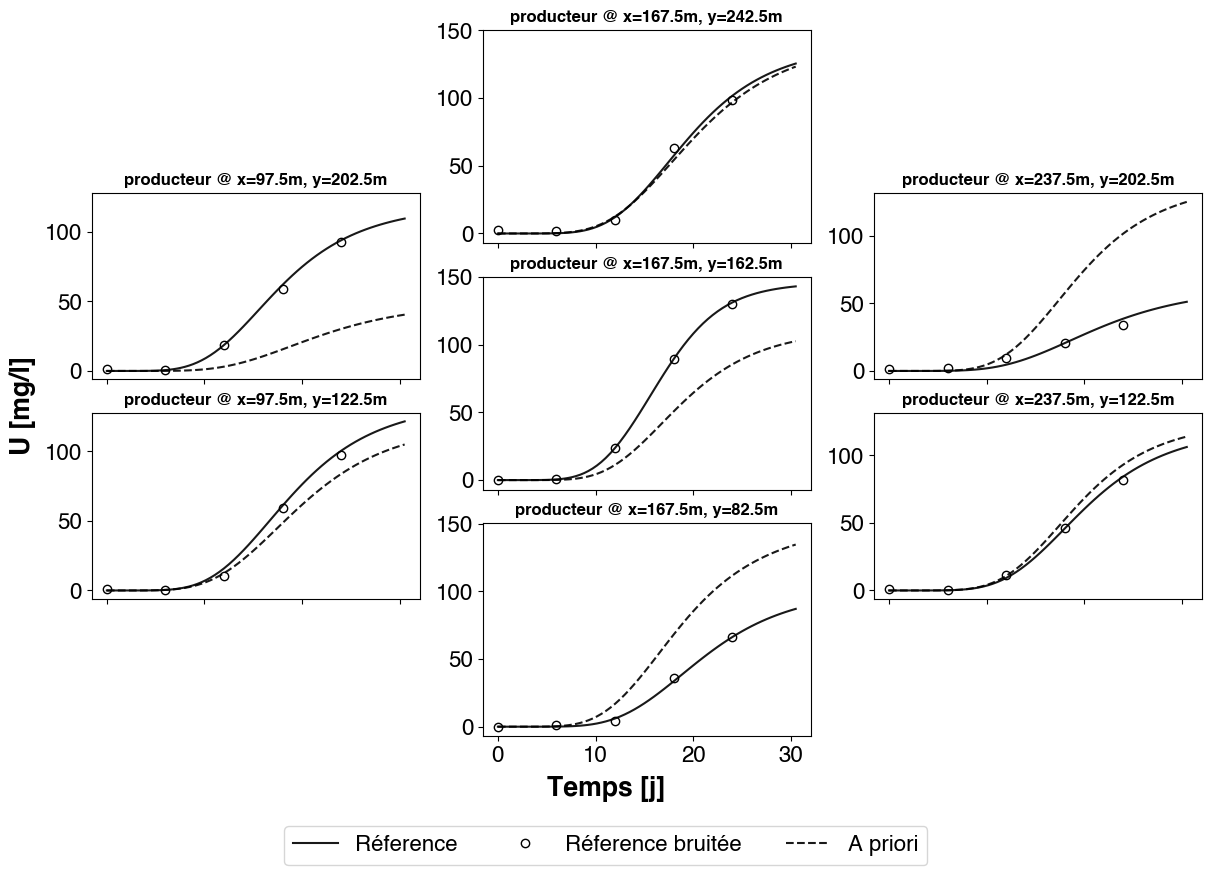

In [56]:
# Indicate the order in which to plot
obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={
        "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
    },
    subplots_mosaic_params={
        "left_col": dict(
            mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
        "centered_col": dict(
            mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
        ),
        "right_col": dict(
            mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
    },
)

# hide axes and borders
plotter.ax_dict["ghost1"].axis("off")
plotter.ax_dict["ghost2"].axis("off")
plotter.ax_dict["ghost3"].axis("off")
plotter.ax_dict["ghost4"].axis("off")

kwargs_obs_conc_curve = (
    {"c": "k", "linestyle": "-", "alpha": 0.9, "zorder": 8}
    if is_gray_scale
    else {"c": "b", "linestyle": "-"}
)
kwargs_obs_conc_points = (
    {
        "c": "k",
        "marker": "o",
        "linestyle": "None",
        "alpha": 1.0,
        "mfc": "none",
        "zorder": 10,
    }
    if is_gray_scale
    else {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2}
)
kwargs_ig_conc_curve = (
    {"c": "k", "linestyle": "--", "alpha": 0.9, "zorder": 9}
    if is_gray_scale
    else {"c": "r", "linestyle": "-"}
)

# Static plot
for count, ((ix, iy), ax_name) in enumerate(zip(prod_grid_indices, obs_plot_locations)):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy

    if language == Lg.ENGLISH:
        obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
    else:
        obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

    ax = plotter.ax_dict[ax_name]
    ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

    if language == Lg.ENGLISH:
        labels = ["Reference", "Reference noisy", "A priori"]
    else:
        labels = ["Réference", "Réference bruitée", "A priori"]

    data = {
        labels[0]: {
            "x": simu_times_ref_in_d,
            "y": conc_molpl_to_mgpl(model_reference.tr_model.conc[ix, iy, :]),
            "kwargs": kwargs_obs_conc_curve,
        },
        labels[1]: {
            "x": obs_times_in_d,
            "y": conc_molpl_to_mgpl(obs_values[count]),
            "kwargs": kwargs_obs_conc_points,
        },
        labels[2]: {
            "x": simu_times_est_in_d,
            "y": conc_molpl_to_mgpl(model_estimate.tr_model.conc[ix, iy, :]),
            "kwargs": kwargs_ig_conc_curve,
        },
    }

    for k, v in data.items():
        ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    # ax.set_xlabel("Time", fontweight="bold")
    # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

plotter.add_fig_legend(ncol=3)

if language == Lg.ENGLISH:
    plotter.fig.supxlabel("Time [d]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")
else:
    plotter.fig.supxlabel("Temps [j]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")

fname = "U_at_producers_before_inv"
for format in ["png", "pdf", "svg"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the cumulative production

In [53]:
# get the factual curve


def get_u_cum_prod_t_per_well_daily_basis(model: dmfwd.ForwardModel) -> NDArrayFloat:
    total_time_d = int(model.time_params.time_elapsed / 3600 / 24) + 1
    _u_cum_t_per_well = np.zeros((len(prod_grid_coordinates), total_time_d))

    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        flw_out_m3pd = (
            model.fl_model.unitflow[ix, iy, 1:]
            * model.time_params.ldt
            * geometry.mesh_volume
        )  # m3
        u_conc_ref_mgpl = conc_molpl_to_mgpl(model.tr_model.conc[ix, iy, 1:])  # mol/l
        _u_cum_t = np.cumsum(-flw_out_m3pd * u_conc_ref_mgpl / 1e6)
        _u_cum_t = np.insert(_u_cum_t, 0, 0.0)

        _u_cum_t_per_well[i] = interp1d(
            model.time_params.times / 3600 / 24, _u_cum_t, kind="cubic"
        )(np.arange(total_time_d))

    # We use an 1D interpolation
    return _u_cum_t_per_well


def get_model_u_cum_prod_t_daily_basis(model: dmfwd.ForwardModel) -> NDArrayFloat:
    return np.sum(get_u_cum_prod_t_per_well_daily_basis(model), axis=0)


u_cum_prod_ref_t = get_model_u_cum_prod_t_daily_basis(model_reference)
u_cum_prod_ig_t = get_model_u_cum_prod_t_daily_basis(model_estimate)

Text(0.5, 0, 'Time [days]')

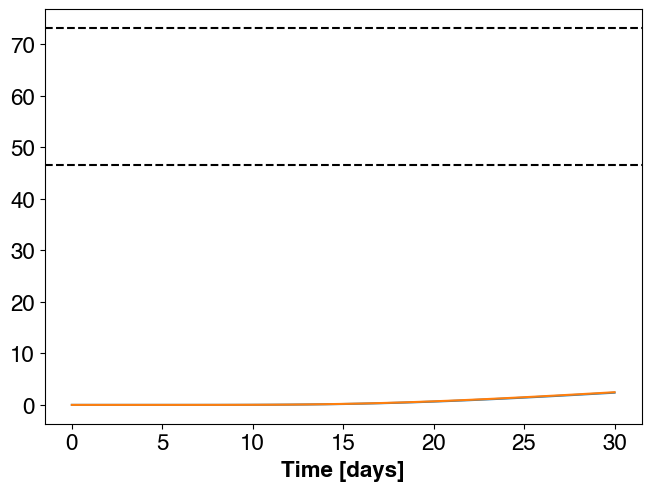

In [54]:
plotter = ngp.NestedGridPlotter()
ax = plotter.axes[0]
ax.plot(u_cum_prod_ig_t, label="initial guess")
ax.plot(u_cum_prod_ref_t, label="reference")

ax.axhline(np.sum(reference_tonnages[1:]), linestyle="--", c="k", label="U in block")
ax.axhline(
    np.sum(reference_tonnages_ext25m[1:]),
    linestyle="--",
    c="k",
    label="U in block + 25m",
)

# ax.plot(ax.plot(, label="initial guess")
# , label="initial guess")

initial_u_dev_simu_cells_ext25m

ax.set_xlabel("Time [days]", fontweight="bold")

- Plot the concentrations and grades for the reference

In [55]:
from typing import List

import nested_grid_plotter as ngp

In [56]:
def get_frame_time_label(
    nb_frames: int, ltimes: List[float]
) -> Generator[str, None, None]:
    """
    Generator of time labels (in d).

    Parameters
    ----------
    nb_frames : int
        Number of frames in the animation.
    ltimes : List[float]
        List of times. The length of the list must be equal or greater than `nb_frames`.
        Times are expected in seconds.

    Yields
    ------
    Generator[str, None, None]
    """
    # subtract -1 to nb_steps and _nb_frames so that when
    # frame_index = 0, we get the first element of ltimes, and when
    # frame_index = _nb_frames - 1, we get the last element of ltimes.
    ts_btw_frames = (len(ltimes) - 1) / (nb_frames - 1)
    for frame in range(nb_frames):
        yield f"time = {ltimes[int(ts_btw_frames * frame)] / 3600 / 24:.1f} d"

In [57]:
if is_export_animations:
    # 1) creation du plotter avec 2 graphiques sur une rangée
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 5)},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
        },
    )

    # 2) ici model_estimate.time_params.nt est le nombre de timesteps, le nombre de frames est donc au max 15.
    nb_frames = min(model_estimate.time_params.nt, 15)

    # 3) Animation des deux graphiques
    # Ici conc_molpl_to_mgpl(model_reference.tr_model.conc) et conc_molpl_to_mgpl(model_estimate.tr_model.conc)
    # sont des np.array 3D avec pour dim (nx, ny, nt)
    plotter.animated_multi_imshow(
        ax_names=["ax1-1", "ax1-2"],
        fig=plotter.fig,
        data={
            "Reference": conc_molpl_to_mgpl(model_reference.tr_model.conc),
            "Initial guess": conc_molpl_to_mgpl(model_estimate.tr_model.conc),
        },
        cbar_title="UO2[2+] [mg/l]",
        imshow_kwargs={
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0.0,
            "vmax": 400.0,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
        nb_frames=nb_frames,
    )

    # 4) Ajout d'un titre à la figure
    plotter.subfigs["fig0"].suptitle("UO2[2+] [mg/l]", fontweight="bold")

    # 5) Ajout d'un texte animé avec le temps correspondant à l'image
    plotter.plot_animated_text(
        ax=plotter.get_axis("ax1-1"),
        x=0.1,
        y=1.04,
        s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis("ax1-1").transAxes,
        fontsize=16,
        fontweight="bold",
    )

    # On ferme (ça c'est requis dans les notebook) puis on anime
    plotter.close()
    plotter.animate(nb_frames=nb_frames)

    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(
        "head_field_reference_vs_initial_guess_animated.html"
    )
    writer = HTMLWriter(fps=5, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation -> jupyter
    HTML(fname_html.read_text())

In [58]:
if is_export_animations:
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 5)},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
        },
    )

    nb_frames = min(model_estimate.time_params.nt, 15)

    plotter.animated_multi_imshow(
        ax_names=["ax1-1", "ax1-2"],
        fig=plotter.fig,
        data={
            "Reference": conc_h2so4_molpl_to_gpl(model_reference.tr_model.conc2),
            "Initial guess": conc_h2so4_molpl_to_gpl(model_estimate.tr_model.conc2),
        },
        cbar_title="H2SO4 [g/l]",
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
        xlabel="X (m)",
        ylabel="Y (m)",
        nb_frames=nb_frames,
    )

    plotter.subfigs["fig0"].suptitle("H2SO4 [g/l]", fontweight="bold")

    plotter.plot_animated_text(
        ax=plotter.get_axis("ax1-1"),
        x=0.1,
        y=1.04,
        s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis("ax1-1").transAxes,
        fontsize=16,
        fontweight="bold",
    )

    plotter.close()
    plotter.animate(nb_frames=nb_frames)

    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(
        "head_field_reference_vs_initial_guess_animated.html"
    )
    writer = HTMLWriter(fps=5, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Display the animation
    HTML(fname_html.read_text())

In [59]:
if is_export_animations:
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 5)},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
        },
    )

    nb_frames = min(model_estimate.time_params.nt, 15)

    plotter.animated_multi_imshow(
        ax_names=["ax1-1", "ax1-2"],
        fig=plotter.fig,
        data={
            "Reference": grade_mol_per_kg_to_ppm(model_reference.tr_model.grade),
            "Initial guess": grade_mol_per_kg_to_ppm(model_estimate.tr_model.grade),
        },
        cbar_title="UO2 [ppm]",
        imshow_kwargs={
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0.0,
            "vmax": 400.0,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
        nb_frames=nb_frames,
    )

    plotter.subfigs["fig0"].suptitle("UO2 [ppm]", fontweight="bold")

    plotter.plot_animated_text(
        ax=plotter.get_axis("ax1-1"),
        x=0.1,
        y=1.04,
        s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis("ax1-1").transAxes,
        fontsize=16,
        fontweight="bold",
    )

    plotter.close()
    plotter.animate(nb_frames=nb_frames)

    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(
        "head_field_reference_vs_initial_guess_animated.html"
    )
    writer = HTMLWriter(fps=5, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Display the animation
    HTML(fname_html.read_text())

In [60]:
if is_export_animations:
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 5)},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
        },
    )

    nb_frames = min(model_estimate.time_params.nt, 15)

    mesh_volume_in_l = geometry.dx * geometry.dy * geometry.dz * porosity * 1000
    gpl_to_t = mesh_volume_in_l / 1e6

    plotter.animated_multi_imshow(
        ax_names=["ax1-1", "ax1-2"],
        fig=plotter.fig,
        data={
            "Reference": conc_h2so4_molpl_to_gpl(model_reference.tr_model.grade2)
            * gpl_to_t,
            "Initial guess": conc_h2so4_molpl_to_gpl(model_estimate.tr_model.grade2)
            * gpl_to_t,
        },
        cbar_title="H2SO4 consummed [t]",
        imshow_kwargs={
            "cmap": plt.get_cmap("plasma"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            # "vmin": 0.0,
            # "vmax": 400.0,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
        nb_frames=nb_frames,
    )

    plotter.subfigs["fig0"].suptitle("H2SO4 consummed [t]", fontweight="bold")

    plotter.plot_animated_text(
        ax=plotter.get_axis("ax1-1"),
        x=0.1,
        y=1.04,
        s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis("ax1-1").transAxes,
        fontsize=16,
        fontweight="bold",
    )

    plotter.close()
    plotter.animate(nb_frames=nb_frames)

    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(
        "head_field_reference_vs_initial_guess_animated.html"
    )
    writer = HTMLWriter(fps=5, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Display the animation
    HTML(fname_html.read_text())

- Define a function to plot the results afterwards

In [61]:
def plot_inv_res_conc_at_producers(
    *,
    ref_model: dmfwd.ForwardModel,
    prior_model: dmfwd.ForwardModel,
    inversed_model: dmfwd.ForwardModel,
    case_name: str,
    sp: int = 0,
) -> ngp.NestedGridPlotter:
    """

    Parameters
    ----------
    ref_model : _type_
        _description_
    prior_model : _type_
        _description_
    inversed_model : _type_
        _description_

    Returns
    -------
    NestedGridPlotter
        _description_
    """
    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 8)},
        subfigs_params={
            "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
        },
        subplots_mosaic_params={
            "left_col": dict(
                mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
            "centered_col": dict(
                mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
            ),
            "right_col": dict(
                mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
        },
    )

    # hide axes and borders
    plotter.ax_dict["ghost1"].axis("off")
    plotter.ax_dict["ghost2"].axis("off")
    plotter.ax_dict["ghost3"].axis("off")
    plotter.ax_dict["ghost4"].axis("off")

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy

        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

        if language == Lg.ENGLISH:
            labels = [
                "Reference",
                "Reference noisy",
                "A priori",
                f"Post-inv ({case_name.upper()})",
            ]
        else:
            labels = [
                "Réference",
                "Réference bruitée",
                "A priori",
                f"Post-inv ({case_name.upper()})",
            ]

        data = {
            labels[0]: {
                "x": simu_times_ref_in_d,
                "y": conc_molpl_to_mgpl(ref_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": kwargs_obs_conc_curve,
            },
            labels[1]: {
                "x": obs_times_in_d,
                "y": conc_molpl_to_mgpl(obs_values[count]),
                "kwargs": kwargs_obs_conc_points,
            },
            labels[2]: {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(prior_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": kwargs_ig_conc_curve,
            },
            labels[3]: {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(inversed_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": {"c": "k", "linestyle": "-.", "zorder": 7}
                if is_gray_scale
                else {"c": "g", "linestyle": "--"},
            },
        }

        for k, v in data.items():
            if v["x"].shape[0] == v["y"].shape[0]:
                ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

        # ax.set_xlabel("Time", fontweight="bold")
        # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

        # Add the end of inversion
        # ax.axvline(x=time_all[obs_time_idx][-1], linestyle="--", color="k", label="fin d'inversion", alpha=0)

        if language == Lg.ENGLISH:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="inversion period",
            )
        else:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="Période inversion",
            )

    plotter.add_fig_legend(ncol=3)

    if language == Lg.ENGLISH:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = f"U_at_producers_post_inv_{case_name}"
    for format in ["png", "pdf", "svg"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)
    return plotter

In [62]:
def plot_inv_res_grade_and_tonnages(
    *,
    ref_grade: NDArrayFloat,
    prior_grade: NDArrayFloat,
    inversed_grade: NDArrayFloat,
    case_name: str,
) -> ngp.NestedGridPlotter:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (15, 7.0)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[
                    ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                    ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
                ],
                sharey=True,
                sharex=True,
            )
        },
    )

    if language == Lg.ENGLISH:
        cbar_title = "Uranium grade [ppm]"
        residuals_label = "Residuals [ppm]"
        data = {
            "Reference": ref_grade,
            "Cond sim": prior_grade,
            f"Post-inv ({case_name.upper()})": inversed_grade,
        }
    else:
        cbar_title = "Teneur en U [ppm]"
        residuals_label = "Résidus [ppm]"
        data = {
            "Réference": ref_grade,
            "Cond sim": prior_grade,
            f"Post-inv ({case_name.upper()})": inversed_grade,
        }

    data_tonnages = {}
    for k, v in data.items():
        data_tonnages[k] = get_sel_u_tonnages(
            v, prod_cells_selection_array, geom=geometry
        )

    # 1) Plot the grades: only for the three first frames
    cbar_up = ngp.multi_imshow(
        axes=plotter.axes[:3],
        fig=plotter.fig,
        data=data,
        cbar_title=cbar_title,
        imshow_kwargs={
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0.0,
            "vmax": 400.0,
        },
        cbar_kwargs={
            "pad": 0.01,
        },
    )

    # 2) Plot residuals / red = over-estimation, blue = underestimation
    cbar_up2 = ngp.multi_imshow(
        axes=plotter.axes[3:4],
        fig=plotter.fig,
        data={residuals_label: inversed_grade - ref_grade},
        cbar_title=residuals_label,
        imshow_kwargs={
            "cmap": bwr_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": -500,
            "vmax": 500,
        },
        cbar_kwargs={
            "pad": 0.01,
        },
        is_symmetric_cbar=True,
    )

    # Add sampling points on both grades and residuals
    add_sampling_points(plotter.axes[:4])

    # 2) Plot the tonnages (not for the last frame)
    plot_tonnages(
        plotter.fig,
        plotter.axes[4:7],
        (list(data.values())),
        is_use_extended_cells=False,
    )

    # 3) Plot the tonnages deviation for the last frame
    plot_tonnages_deviations(
        plotter.fig,
        plotter.axes[-1:],
        (inversed_grade,),
        is_use_extended_cells=False,
        ref_axis=-1,
    )

    # Box dimensions
    for ax in plotter.ax_dict.values():
        ax.set_xlim(0, nx * dx)
        ax.set_ylim(0, ny * dy)
        ax.set_aspect("equal", adjustable="box")

    # plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
    plotter.fig.supxlabel("X [m]", fontweight="bold")
    plotter.fig.supylabel("Y [m]", fontweight="bold")

    # add letters a, b, c...
    ngp.add_letter_to_frames(plotter.axes)

    fname = f"tonnages_and_grades_per_cells_post_inv_{case_name}"
    for format in ["png", "pdf", "svg"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )
    return plotter

## Inversion tests

- Define a threshold (minimum objective function)

In [63]:
def loss_target_fct(observables: List[dminv.Observable], n_std: float = 5) -> float:
    """
    The threshold for the loss function is given by Gao et al. 2006.

    It is propotionnal to the number of observations. And assume that the observation
    noise is well known.
    """
    n_obs = np.sum([obs.values.size for obs in observables])
    return 0.5 * n_obs + n_std * np.sqrt(0.5 * n_obs)

In [64]:
if is_run_asm:
    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    # regularizator=dminv.regularization.GeostatisticalRegularizator(
    #     cov_m=dminv.regularization.SparseInvCovarianceMatrix(Q_init),
    #     prior=dminv.regularization.MeanPriorTerm(),
    #     preconditioner=pcd,
    # )

    adjusted_param_adjoint = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
        ubounds=float(grade_ppm_to_mol_per_kg(2000.0)[0]),
        preconditioner=pcd,
        # regularizators=regularizator,
        # filters=[GaussianFilter(sigmas=(2.0))],
        # reg_weight_update_strategy=dminv.regularization.ConstantRegWeight(1.0),
        sp=0,
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # Careful not to forget the x2

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

    loss_target = loss_target_fct(observables)
    logging.info(f"loss_target = {loss_target:.2g}")

    # Add well data -> With the uncertainty
    # observables.append(
    #     dminv.Observable(
    #         state_variable=dminv.StateVariable.GRADE,
    #         node_indices=dat_nn,
    #         times=np.zeros(dat_nn.size, dtype=np.float_),
    #         values=grade_ppm_to_mol_per_kg(dat_val_wrong),
    #         uncertainties=grade_ppm_to_mol_per_kg(np.sqrt(dat_var_init)),
    #         sp=0,
    #     )
    # )

    # Create an executor to keep track of the adjoint model
    solver_config_adjoint = dminv.LBFGSBSolverConfig(
        maxfun=20,
        maxiter=20,
        ftarget=loss_target,
        gtol=1e-5,
        ftol=1e-3,
        is_check_gradient=False,
        is_adj_numerical_acceleration=False,
        afpi_eps=1e-5,
    )
    model_adjusted_adjoint = copy.deepcopy(model_estimate)
    model_adjusted_adjoint.time_params.duration = duration_in_seconds_inv

    inverse_model_adjoint = dminv.InverseModel(adjusted_param_adjoint, observables)
    executor_adjoint = dminv.LBFGSBInversionExecutor(
        model_adjusted_adjoint, inverse_model_adjoint, solver_config_adjoint
    )

    # Compute a first objective function
    executor_adjoint.eval_scaled_loss(
        get_param_values(adjusted_param_adjoint, is_preconditioned=True),
        is_save_state=False,
    )

    # grad2 = executor_adjoint.eval_scaled_loss_gradient(
    #     get_param_values(adjusted_param_adjoint, is_preconditioned=True),
    # )

In [65]:
if is_run_asm:
    res = executor_adjoint.run()

In [66]:
if is_run_asm:
    logging.info(res)

- Run a full simulation with hm

In [67]:
if is_run_asm:
    model_adjusted_adjoint_full = copy.deepcopy(model_adjusted_adjoint)
    model_adjusted_adjoint_full.time_params.duration = duration_in_seconds

    solver_adjusted_adjoint = dmfwd.ForwardSolver(model_adjusted_adjoint_full)
    solver_adjusted_adjoint.solve()

In [68]:
if is_run_asm:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_adjoint_full,
        case_name="ASM",
        sp=0,
    )

In [69]:
if is_run_asm:
    plot_inv_res_grade_and_tonnages(
        ref_grade=reference_grade_ppm,
        prior_grade=estimate_grade_simu_ppm,
        inversed_grade=grade_mol_per_kg_to_ppm(
            model_adjusted_adjoint_full.tr_model.grade[:, :, 0]
        ),
        case_name="asm",
    )

In [70]:
if is_run_asm:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_adjoint.nb_f_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_adjoint, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            "cmap": bwr_cmap,
        },
        xlabel="X [m]",
        ylabel="Y [m]",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    if language == Lg.ENGLISH:
        labels = [
            "Uranium grade [ppm]",
            "Cost function",
        ]
    else:
        labels = [
            "Teneurs en U  [ppm]",
            "Fonction de perte",
        ]

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            labels[0]: grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_adjoint.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0,
            "vmax": 400,
        },
        xlabel="X [m]",
        ylabel="Y [m]",
    )

    plotter.get_axis("ax1-2").set_title(f"{labels[0]} [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_adjoint.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            labels[1]: {
                "y": obj_fun_vals,
                "kwargs": {"c": "k" if is_gray_scale else "r", "linestyle": "--"},
            },
        },
        nb_frames=nb_frames,
        title=labels[1],
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values

    print(conc_molpl_to_mgpl(dminv.get_observables_values_as_1d_vector(observables)))
    print(
        conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(model_estimate, observables)
        )
    )
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(model_estimate, observables)
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_adjoint.inv_model.list_d_pred).T
                ),
                "kwargs": {
                    "c": "k" if is_gray_scale else "b",
                    "linestyle": "none",
                    "marker": ".",
                    "zorder": 2,
                },
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    # Add letters a, b, c ...
    ngp.add_letter_to_frames(plotter.axes)

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_adjoint.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

## Inversion with PCGA

- Check what kernel to use for PyPCGA (not great though...) must refactor the lib.

In [71]:
def matern_kernel(r: NDArrayFloat, l: float = 1, v: float = 1) -> NDArrayFloat:
    """
    Computes Matérn correlation function for given distances.

    Parameters:
    -----------
    r : array
        Distances between locations.
    l : float
        Range parameter (ϕ). Must be greater than 0.
    v : float
        Smoothness parameter (nu). Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    r = np.abs(r)
    r[r == 0] = 1e-8
    return (
        2 ** (1 - v)
        / sp.special.gamma(v)
        * (np.sqrt(2 * v) * r / l) ** v
        * sp.special.kv(v, np.sqrt(2 * v) * r / l)
    )


def matern_kernel_wrapper(r: NDArrayFloat) -> NDArrayFloat:
    # This is in mol/kg
    spatial_dim = 2
    _nu = 2 * alpha - spatial_dim / 2
    # return (grade_ppm_to_mol_per_kg(estimated_std) ** 2) * matern_kernel(
    #     r * len_scale, len_scale, _nu
    # )
    return estimated_std**2 * matern_kernel(r * len_scale, len_scale, _nu)

In [72]:
from pyrtid.inverse.regularization import (
    FFTCovarianceMatrix,
    get_prior_eigen_factorization,
)

cov_mat_fft = FFTCovarianceMatrix(
    matern_kernel_wrapper, (dx, dy), (nx, ny), (1 / kappa, 1 / kappa), 0.0
)
cov_mat_spde = SparseInvCovarianceMatrix(Q_init)

eigval_fft, eigvec_fft = get_prior_eigen_factorization(
    cov_mat_fft,
    100,
    random_state=rng,
)
cov_mat_spde_scaled = SparseInvCovarianceMatrix(Q_init, cholQ_init)

eigval_spde, eigvec_spde = get_prior_eigen_factorization(
    cov_mat_spde_scaled, 100, random_state=rng
)

INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 2 sec
INFO:root:- 1st eigv : [3788893.86734573], 100-th eigv : [361099.4616455], ratio: [0.09530472]
INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 1 sec
INFO:root:- 1st eigv : [6992027.02686695], 100-th eigv : [214998.84390855], ratio: [0.03074914]


INFO:root:Tree building time = 0.0007777214050292969
INFO:root:Nearest neighbor computation time = 0.04369997978210449
INFO:root:Elapsed time = 31.2702
INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 1 sec
INFO:root:- 1st eigv : 0.000984285, 100-th eigv : 9.3807e-05, ratio: 0.0953047
INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 2 sec
INFO:root:- 1st eigv : 0.0018164, 100-th eigv : 5.58527e-05, ratio: 0.0307491

- Plot the eigen values and the associated explained variance in order to choose the number of principal component required for the inversion.

INFO:root:n pc (50% variance spde case) = 24
INFO:root:n pc (80% variance spde case) = 101


([<matplotlib.lines.Line2D at 0x7bba39489710>,
 ['fft', 'spde'])

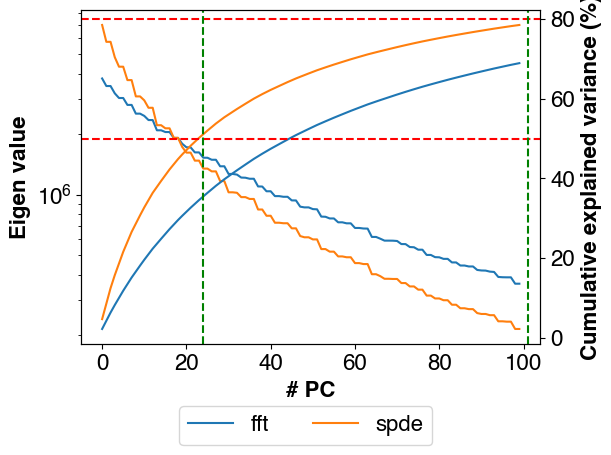

In [73]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 4)}
)

# fig, ax = plt.subplots(1, 1)
ax = plotter.axes[0]

variance_threshold_1 = 0.5  # we want to keep 90% of the explained variance
variance_threshold_2 = 0.8  # we want to keep 90% of the explained variance
# eigen values
ax.plot(eigval_fft, label="fft")
ax.plot(eigval_spde, label="spde")
ax.set_yscale("log")
ax.set_xlabel("# PC", fontweight="bold")
ax.set_ylabel("Eigen value", fontweight="bold")

n_pc_threshold_1 = (
    np.searchsorted(
        np.cumsum(get_explained_var(eigval_spde, cov_mat_spde)), variance_threshold_1
    )
    + 1
)
n_pc_threshold_2 = (
    np.searchsorted(
        np.cumsum(get_explained_var(eigval_spde, cov_mat_spde)), variance_threshold_2
    )
    + 1
)
logging.info(f"n pc (50% variance spde case) = {n_pc_threshold_1}")
logging.info(f"n pc (80% variance spde case) = {n_pc_threshold_2}")


# Variance
ax2 = plt.twinx(ax)
ax2.plot(np.cumsum(get_explained_var(eigval_fft, cov_mat_fft)) * 100.0, label="fft")
ax2.plot(
    np.cumsum(get_explained_var(eigval_spde, cov_mat_spde_scaled)) * 100.0, label="spde"
)

ax2.axhline(variance_threshold_1 * 100.0, linestyle="--", color="r")
ax2.axhline(variance_threshold_2 * 100.0, linestyle="--", color="r")
ax2.axvline(n_pc_threshold_1, linestyle="--", color="g")
ax2.axvline(n_pc_threshold_2, linestyle="--", color="g")
ax2.set_ylabel("Cumulative explained variance (%)", fontweight="bold")

plotter.add_fig_legend(ncol=2)

- Keeping 50 eigen values

In [74]:
logging.info(
    f"variance explained keeping {n_pc} PC: {(np.cumsum(get_explained_var(eigval_spde, cov_mat_spde_scaled)) * 100.0)[n_pc]}"
)

INFO:root:variance explained keeping 5 PC: 21.579704329568848


Text(0.02, 0.5, 'Y [m]')

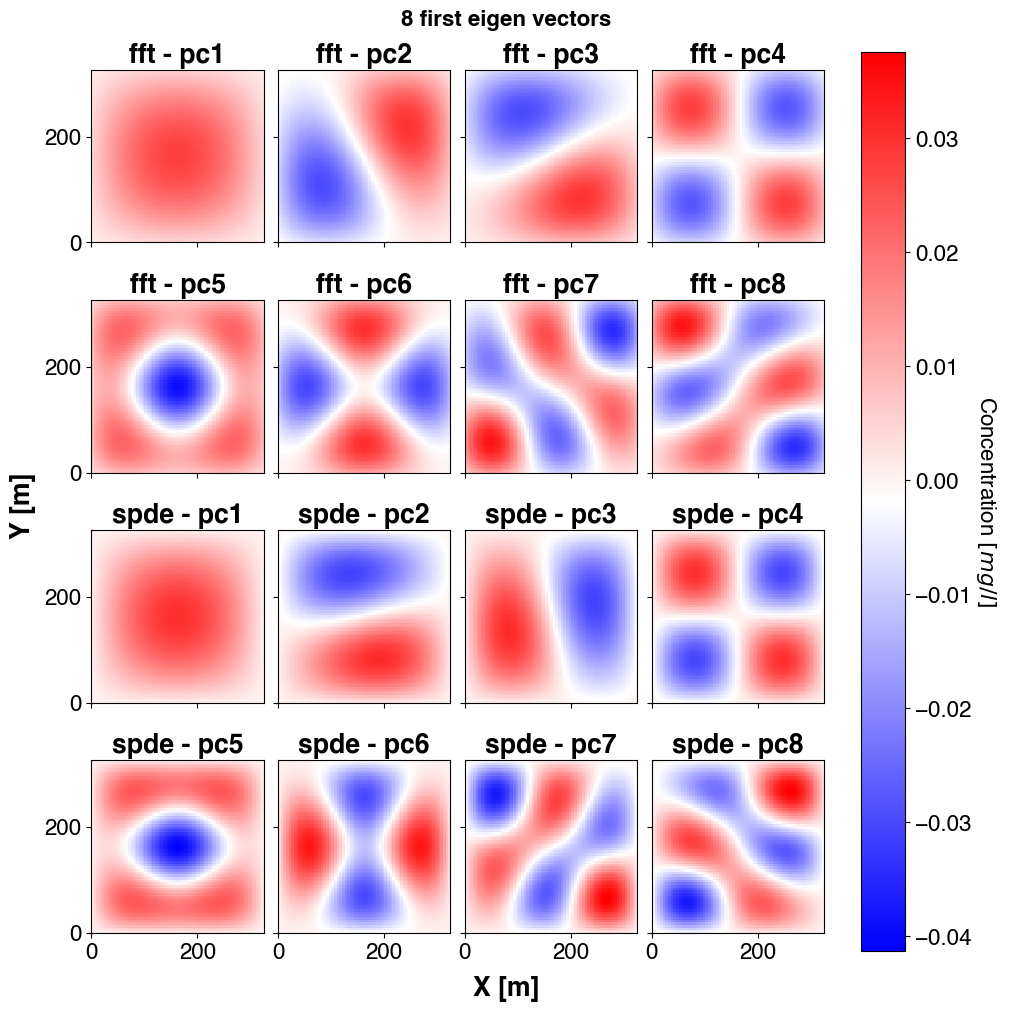

In [75]:
# Plot a concentration animation Here !
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
                ["ax3-1", "ax3-2", "ax3-3", "ax3-4"],
                ["ax4-1", "ax4-2", "ax4-3", "ax4-4"],
            ],
            sharey=True,
            sharex=True,
        ),
    },
)


# 1) FFT et SPDE
ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        **{f"fft - pc{i + 1}": eigvec_fft[:, i].reshape(nx, ny) for i in range(8)},
        **{f"spde - pc{i + 1}": eigvec_spde[:, i].reshape(nx, ny) for i in range(8)},
    },
    cbar_title="Concentration $[mg/l]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

plotter.subfigs["fig0"].suptitle("8 first eigen vectors", fontweight="bold", size=16)
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y [m]", fontweight="bold")

In [76]:
eigvec_spde.shape

(4225, 100)

# Old version of pypcga executor

In [77]:
from dataclasses import dataclass
from typing import Any, Optional, Sequence, Union

from pyPCGA import PCGA
from pyrtid.inverse.executors.base import (
    BaseInversionExecutor,
    BaseSolverConfig,
)
from pyrtid.inverse.solvers import PCGA
from pyrtid.utils.types import NDArrayFloat


@dataclass
class PCGASolverConfigOld(BaseSolverConfig):
    """
    Principal Component Geostatistical Approach Inversion Configuration.

    Attributes
    ----------
    is_verbose: bool
        Whether to display inversion information. The default True.
    hm_end_time: Optional[float]
        Time at which the history matching ends and the forecast begins.
        This is not to confuse with the simulation `duration` which
        is already defined by the user in the htc file. The units are the same as
        given for the `duration` keyword in :term:`HYTEC`.
        If None, hm_end_time is set to the end of the simulation and
        all observations covering the simulation duration are taken into account.
        The default is None.
    is_parallel: bool, optional
        Whether to run the calculation one at the time or in a concurrent way.
    max_workers: int, optional
        Number of workers to use if the concurrency is enabled. The default is 2.
    random_state: Optional[Union[int, np.random.Generator, np.random.RandomState]]
        Pseudorandom number generator state used to generate resamples.
        If `random_state` is ``None`` (or `np.random`), the
        `numpy.random.RandomState` singleton is used.
        If `random_state` is an int, a new ``RandomState`` instance is used,
        seeded with `random_state`.
        If `random_state` is already a ``Generator`` or ``RandomState``
        instance then that instance is used.
    solver_kwargs: Optional[Dict[str, Any]]
        Additional arguments for PCGA instance. The default is None.
    """

    solver_kwargs: Optional[Dict[str, Any]] = None


class PCGAInversionExecutorOld(BaseInversionExecutor[PCGASolverConfigOld]):
    """Principal Component Geostatistical Approach Inversion Executor."""

    def _init_solver(self, s_init: Optional[NDArrayFloat] = None) -> None:
        """Initiate a solver with its args."""
        # Array with grid coordinates. (X, Y, Z)...
        # Note: for regular grid you don't need to specify pts.
        self.pts = None
        self.solver: PCGA = PCGA(
            self._map_forward_model_wrapper,
            self.data_model.s_init.ravel(),  # Need to be a vector
            self.pts,
            params=self.solver_config.solver_kwargs,
            obs=self.data_model.obs,
            random_state=self.solver_config.random_state,
        )

    def _get_solver_name(self) -> str:
        """Return the solver name."""
        return "PCGA"

    def run(self) -> Optional[Sequence[Any]]:
        """
        Run the history matching.

        First is creates raw folders to store the different runs
        required by the HM algorithms.
        """
        super().run()
        return self.solver.Run()

    def _map_forward_model_wrapper(
        self, s_ensemble: NDArrayFloat, is_parallel: bool = False, ncores: int = 1
    ) -> NDArrayFloat:
        """
        Call the forward model for all ensemble members, return predicted data.

        Function calling the non-linear observation model (forward_model)
        for all ensemble members and returning the predicted data for
        each ensemble member. this function is responsible for the creation of
        simulation folder etc.

        Returns
        -------
        None.
        """
        # pylint: disable=W0613  # Unused argument 'ncores'
        # The transposition is due to the implementation of pypcga
        return super()._map_forward_model(s_ensemble)

In [78]:
if is_run_pcga or is_run_pcga_old:
    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # Careful not to forget the x2

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

if is_run_pcga_old:
    adjusted_param_pcga_old = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
        ubounds=grade_ppm_to_mol_per_kg(700.0)[0],
        preconditioner=dminv.ChainedTransforms(
            [
                dminv.LinearTransform(slope=1 / conv_u_grade, y_intercept=0.0),
                dminv.BoundsClipper(1.0, 2000.0),  # bounds = [1, 2000] ppm
            ]
        ),
        sp=0,
    )

    xmin: NDArrayFloat = np.array([0.5 * dx, 0.5 * dy])
    xmax: NDArrayFloat = np.array([(nx - 0.5) * dx, (ny - 0.5) * dy])

    solver_kwargs = {
        "R": (noise_std) ** 2,
        "n_pc": n_pc,
        "maxiter": 5,
        "restol": loss_target_fct(observables),
        "matvec": "FFT",
        "xmin": xmin,
        "xmax": xmax,
        "N": np.array((nx, ny), dtype=np.int8),
        "prior_std": estimated_std,  # 150 ppm
        "prior_cov_scale": np.array([1 / kappa, 1 / kappa]),
        "kernel": matern_kernel_wrapper,
        "post_cov": "diag",
        "precond": True,
        "LM": False,
        "parallel": is_parallel,
        "linesearch": False,
        "forward_model_verbose": False,
        "verbose": True,
        "iter_save": True,
        "direct": True,
    }

## OLD PCGA

In [79]:
if is_run_pcga_old:
    model_adjusted_pcga_old = copy.deepcopy(model_estimate)
    model_adjusted_pcga_old.time_params.duration = duration_in_seconds_inv

    solver_config_pcga_old = PCGASolverConfigOld(
        is_parallel=is_parallel,
        max_workers=max_workers,  # max four processes in parrallel.
        solver_kwargs=solver_kwargs,
        # hm_end_time=model_adjusted_pcga_old.time_params.duration
    )

    inverse_model_reg2b_pcga_old = dminv.InverseModel(
        adjusted_param_pcga_old, observables
    )

    executor_pcga_old = PCGAInversionExecutorOld(
        model_adjusted_pcga_old, inverse_model_reg2b_pcga_old, solver_config_pcga_old
    )

    # Compute a first objective function
    executor_pcga_old.eval_scaled_loss(
        get_param_values(adjusted_param_pcga_old, is_preconditioned=True),
        is_save_state=True,
    )

In [80]:
# Run inversion
if is_run_pcga_old:
    (
        _s_inversed_best_pcga_old,
        simul_obs_best_pcga_old,
        post_diagv_best_pcga_old,
        iter_best_pcga_old,
    ) = executor_pcga_old.run()

    # make sure to have ppm
    _s_inversed_best_pcga_old_ppm = grade_mol_per_kg_to_ppm(
        adjusted_param_pcga_old.preconditioner.backtransform(_s_inversed_best_pcga_old)
    ).reshape(nx, ny, order="F")

## New PCGA

In [81]:
if is_run_pcga:
    adjusted_param_pcga = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
        ubounds=float(grade_ppm_to_mol_per_kg(2000.0)[0]),
        preconditioner=dminv.ChainedTransforms(
            [
                dminv.LinearTransform(slope=1 / conv_u_grade, y_intercept=0.0),
                dminv.BoundsClipper(1.0, 2000.0),  # bounds = [1, 2000] ppm
            ]
        ),
        sp=0,
    )

    # Define a callback function to save the results somewhere
    eig_cov = dminv.regularization.EigenFactorizedCovarianceMatrix(
        eigval_spde[:n_pc], eigvec_spde[:, :n_pc]
    )

    def pcga_callback(
        solver: PCGA,
        *args,
        s_hat: NDArrayFloat,
        simul_obs: NDArrayFloat,
        n_iter: int,
        **kwargs,
    ) -> None:
        """
        Save some intermediate PCGA results to the disk.

        The callback is called at the end of each iterations. The goal is to save
        intermediate results.

        Parameters
        ----------
        solver: PCGA
            PCGA instance accessed by the solver.

        """
        # create a folder to store the results if it does not exists
        _save_path = Path(ipynb_path, "pcga_results")
        _save_path.mkdir(parents=True, exist_ok=True)

        # save the current optimized values vector
        np.savetxt(_save_path.joinpath(f"shat_{n_iter}.txt"), s_hat)
        # save the simulated values
        np.savetxt(_save_path.joinpath(f"dpred_{n_iter}.txt"), simul_obs)

    solver_config_pcga = dminv.PCGASolverConfig(
        is_parallel=is_parallel,
        max_workers=max_workers,  # max four processes in parrallel.
        maxiter=10,
        ftarget=loss_target_fct(observables),
        eig_cov=eig_cov,
        prior_s_var=estimated_field_var_ppm,
        post_cov_estimation="direct",
        is_direct_solve=True,
        is_post_cov=True,
        callback=pcga_callback,
        random_state=2024,
    )

    model_adjusted_pcga = copy.deepcopy(model_estimate)
    model_adjusted_pcga.time_params.duration = duration_in_seconds_inv

    inverse_model_reg2b_pcga = dminv.InverseModel(adjusted_param_pcga, observables)

    executor_pcga = dminv.PCGAInversionExecutor(
        model_adjusted_pcga, inverse_model_reg2b_pcga, solver_config_pcga
    )

    # Compute a first objective function
    executor_pcga.eval_scaled_loss(
        get_param_values(adjusted_param_pcga, is_preconditioned=True),
        is_save_state=False,
    )

In [82]:
# Run inversion
if is_run_pcga:
    (
        _s_inversed_best_pcga,
        simul_obs_best_pcga,
        post_diagv_best_pcga,
        iter_best_pcga,
    ) = executor_pcga.run()

    # make sure to have ppm
    _s_inversed_best_pcga_ppm = grade_mol_per_kg_to_ppm(
        adjusted_param_pcga.preconditioner.backtransform(_s_inversed_best_pcga)
    ).reshape(nx, ny, order="F")

In [83]:
np.abs(130 - 296) / (max(abs(300.0), abs(130), 1))

0.5533333333333333

- Plot inverted fields

In [84]:
if is_run_pcga_old:
    plot_inv_res_grade_and_tonnages(
        ref_grade=reference_grade_ppm,
        prior_grade=estimate_grade_simu_ppm,
        inversed_grade=_s_inversed_best_pcga_old_ppm,
        case_name="PCGA_old",
    )

In [85]:
if is_run_pcga:
    plot_inv_res_grade_and_tonnages(
        ref_grade=reference_grade_ppm,
        prior_grade=estimate_grade_simu_ppm,
        inversed_grade=_s_inversed_best_pcga_ppm,
        case_name="PCGA",
    )

- Need to run PCGA once again

In [86]:
def plot_pcga_loss_ls(executor: dminv.PCGAInversionExecutor, case: str):
    losses_pcga = copy.copy(executor.solver.istate.objvals)
    # losses_pcga = [loss / losses_pcga[0] for loss in losses_pcga]
    pcga_loss_index = 0

    loss_target = loss_target_fct(observables)

    for pcga_loss_index, loss in enumerate(losses_pcga):
        if loss < loss_target:
            break

    logging.info(f"pcga_loss_index = {pcga_loss_index}")
    plotter = ngp.NestedGridPlotter()
    ax = plotter.axes[0]
    ax.axhline(loss_target, label="stop criterion", linestyle="--", c="r")
    ax.plot(losses_pcga)
    ax.set_yscale("log")
    plotter.savefig(fig_save_path.joinpath(f"loss_ls_{case}.svg"), format="svg")


if is_run_pcga:
    plot_pcga_loss_ls(executor_pcga, "pcga")


# if is_run_pcga_old:
#     plot_pcga_loss_ls(executor_pcga_old, "pcga_old")

In [87]:
if is_run_pcga:
    model_adjusted_pcga.tr_model.set_initial_grade(adjusted_param_pcga.values)
    model_adjusted_pcga.time_params.duration = duration_in_seconds
    solver_pcga_post_inv = dmfwd.ForwardSolver(model_adjusted_pcga)
    solver_pcga_post_inv.solve()

In [88]:
if is_run_pcga:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_pcga,
        case_name="pcga",
        sp=0,
    )

In [89]:
if is_run_pcga and is_run_asm:
    plotter = plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_adjoint_full,
        case_name="ASM",
    )

    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy
        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        data = {
            "Post-inversion (PCGA)": {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(model_adjusted_pcga.tr_model.conc[ix, iy, :]),
                "kwargs": {"c": "k", "linestyle": ":"},
            },
        }

        for k, v in data.items():
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    plotter.add_fig_legend(ncol=3)
    if language == Lg.FRENCH:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = "U_at_producers_post_inv_asm_pcga"
    for format in ["png", "pdf", "svg"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot uncertainties

In [90]:
if is_run_pcga:
    plt.imshow(
        np.sqrt(post_diagv_best_pcga).reshape(nx, ny, order="F").T,
        origin="lower",
        cmap=jet_cmap,
    )
    plt.colorbar()

- Plot the objective function deacrease

# Inversion with ensemble smoothers

- Generate a 100 fields for the inversion

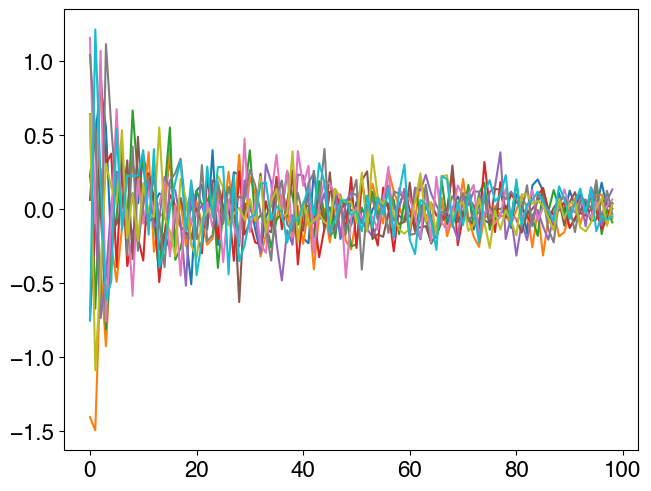

In [39]:
for i in range(10):
    plt.plot(get_theta_init_normal(ne, mu=0.0, sigma=1.0, random_state=i * 536))

In [40]:
if is_run_ensembles:
    tmp = []
    for i in range(n_fields_es):
        _field = (
            pcd.backtransform(
                np.hstack(
                    [
                        get_theta_init_normal(
                            ne, mu=0.0, sigma=1.0, random_state=i * 563
                        ),
                        estimated_mean,
                    ]
                )
            )
            .reshape(nx, ny, order="F")
            .T
        )

        tmp.append(_field.ravel("F"))
    initial_ensemble_values_molpl = np.array(tmp)
    initial_ensemble_values_ppm = grade_mol_per_kg_to_ppm(initial_ensemble_values_molpl)
    ensemble_shape = initial_ensemble_values_molpl.T.shape
    print(ensemble_shape)

(4225, 10)


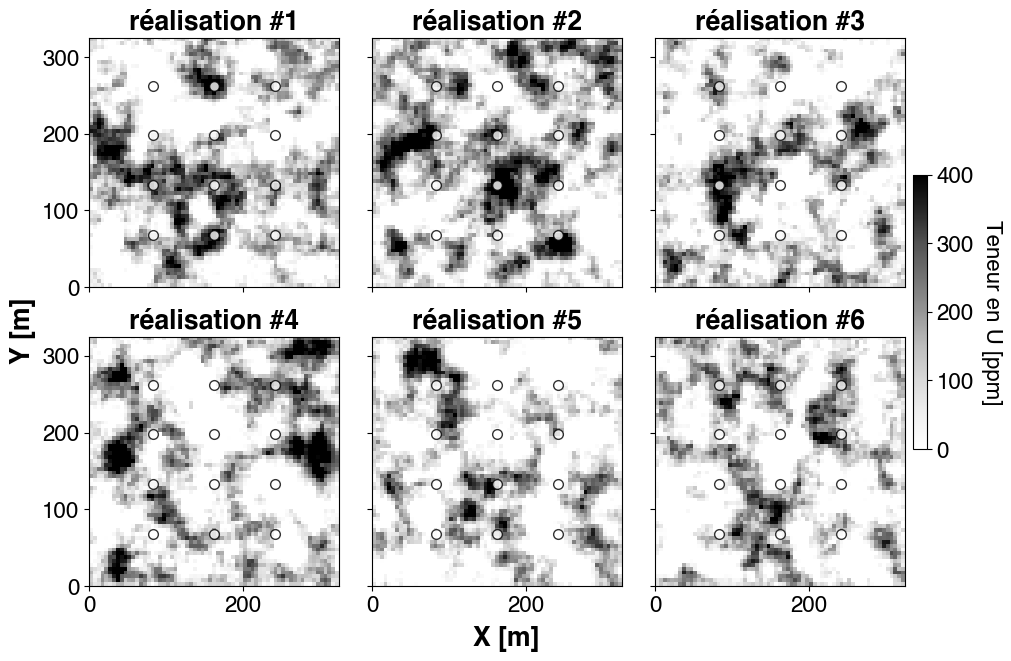

In [55]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10.0, 6.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[[f"ax{i+1}-{j+1}" for j in range(3)] for i in range(2)],
            sharey=True,
            sharex=True,
        )
    },
)
cbar_up = ngp.multi_imshow(
    axes=plotter.axes[:n_fields_es],
    fig=plotter.fig,
    data={
        f"réalisation #{_n+1}": initial_ensemble_values_ppm[_n].reshape(
            nx, ny, order="F"
        )
        for _n in range(min(len(plotter.axes), n_fields_es))
    },
    cbar_title=cbar_title,
    imshow_kwargs={
        "cmap": jet_cmap,
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0,
        "vmax": 400,
        "aspect": "equal",
    },
    cbar_kwargs={"pad": 0.01, "shrink": 0.5},
)
plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Y [m]", fontweight="bold")
add_sampling_points(plotter.axes)

plt.savefig(fig_save_path.joinpath("realizations.pdf"))
plt.savefig(fig_save_path.joinpath("realizations.png"))

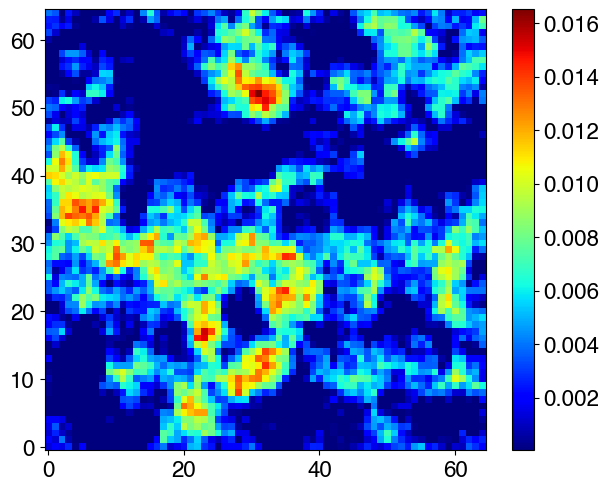

In [94]:
if is_run_ensembles:
    plt.imshow(
        initial_ensemble_values_molpl[0].reshape(nx, ny),
        cmap=jet_cmap,
        origin="lower",
    )
    plt.colorbar()

In [95]:
# if is_run_asm and is_run_ensembles:
#     # Define a covariance matrix without any datapoints
#     # cov_m = SparseInvCovarianceMatrix(Q_init)
#     cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

#     # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
#     reg_adjoint = dminv.regularization.EnsembleRegularizator(
#         cov_m=cov_m,
#         prior=dminv.regularization.EnsembleMeanPriorTerm(ensemble_shape),
#         is_preconditioned=False,
#         transform=grade_mol_per_kg_to_ppm,
#         transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
#     )

#     adjusted_param_adjoint = dminv.AdjustableParameter(
#         name=dminv.ParameterName.INITIAL_GRADE,
#         lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
#         ubounds=float(grade_ppm_to_mol_per_kg(700.0)[0]),
#         regularizators=[reg_adjoint],
#         # span=(slice(4, -4), slice(4, -4)) # exclude the border
#         filters=[GaussianFilter(sigmas=(2.0))],
#         # TODO: is there an effect of preconditonning ? -> very bad for now...
#         # preconditioner=normalize_to_bounds,
#         # preconditioner_1st_derivative=normalize_to_bounds_first_derivative,
#         # backconditioner=backnormalize_to_bounds,
#     )

#     observables = []
#     for i, (ix, iy) in enumerate(prod_grid_indices):
#         # Careful not to forget the x2

#         observables.append(
#             dminv.Observable(
#                 state_variable=dminv.StateVariable.CONCENTRATION,
#                 node_indices=indices_to_node_number(ix, nx, iy),
#                 times=obs_times_in_s,
#                 values=obs_values[i],
#                 uncertainties=noise_std,
#             )
#         )

#     # Add well data -> With the uncertainty
#     observables.append(
#         dminv.Observable(
#             state_variable=dminv.StateVariable.GRADE,
#             node_indices=dat_nn,
#             times=np.zeros(dat_nn.size, dtype=np.float_),
#             values=grade_ppm_to_mol_per_kg(dat_val_wrong),
#             uncertainties=grade_ppm_to_mol_per_kg(np.sqrt(dat_var_init)),
#         )
#     )

#     # Create an executor to keep track of the adjoint model
#     solver_config_adjoint = dminv.LBFGSBSolverConfig(
#         maxfun=25,
#         max_iter=25,
#         ftol=loss_target_fct(observables),
#         gtol=1e-6,
#         is_check_gradient=False,
#         is_regularization_at_first_round=True,
#         n_fun_before_reg=2,  # worked great with 1 and no well data
#         reg_factor=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
#     )
#     model_adjusted_adjoint = copy.deepcopy(model_estimate)
#     model_adjusted_adjoint.time_params.duration = duration_in_seconds_inv

#     inverse_model_adjoint = dminv.InverseModel(adjusted_param_adjoint, observables)
#     executor_adjoint = LBFGSBEnsembleInversionExecutor(
#         model_adjusted_adjoint,
#         inverse_model_adjoint,
#         solver_config_adjoint,
#         s_init=initial_ensemble_values_molpl.T,
#     )

#     # Compute a first objective function
#     # executor_adjoint.eval_scaled_loss(
#     #     initial_ensemble_values_molpl.T,
#     #     is_save_state=False,
#     # )

#     # grad2 = executor_adjoint.eval_scaled_loss_gradient(
#     #     get_param_values(adjusted_param_adjoint, is_preconditioned=True),
#     # )

In [96]:
# res = executor_adjoint._map_forward_model_with_adjoint(initial_ensemble_values_molpl.T)

- Plot the std of the ensemble

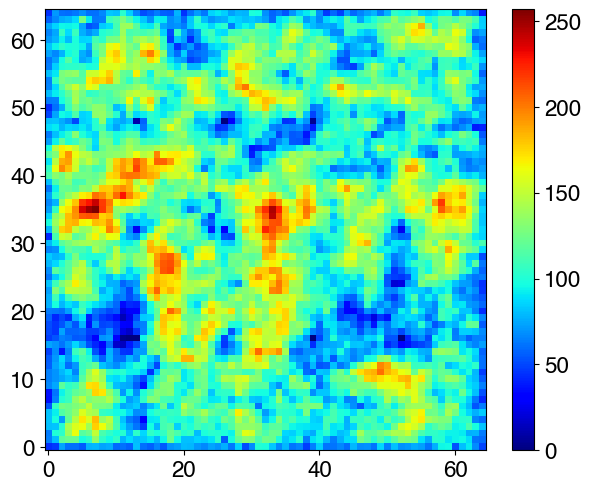

In [97]:
if is_run_ensembles:
    prior_var = get_ensemble_variance(initial_ensemble_values_ppm.T)

    plt.imshow(
        np.sqrt(prior_var).reshape(nx, ny, order="F").T, cmap=jet_cmap, origin="lower"
    )
    plt.colorbar()

- Create correlation matrices to avoid spourious correlations

In [98]:
# Vectors of x and y coordinates (case of a regular grid)
x_vect_coords = np.linspace(0, (nx - 1) * dx, nx)
y_vect_coords = np.linspace(0, (ny - 1) * dy, ny)

# Build grid coordinates from it -> 2D array with dimensions (nx * ny, 2)
coordinates = np.array(np.meshgrid(x_vect_coords, y_vect_coords)).reshape(2, -1).T

# 20 cells expected
logging.info(f"coordinates.shape = {coordinates.shape}")

# mesh indices
mesh_indices = np.arange(nx * ny).reshape(ny, nx)

INFO:root:coordinates.shape = (4225, 2)


- The distance and weight matrices can be directly computed from these two vectors

In [99]:
obs_size_per_well = obs_times_in_d.size
obs_size_per_well

5

In [100]:
# one coordinates set per obs value
obs_val_coords = np.concatenate(
    [
        [prod_grid_coordinates[i]] * obs_size_per_well
        for i in range(len(prod_grid_coordinates))
    ],
    axis=0,
)
obs_val_coords.shape

(35, 2)

In [101]:
coordinates.shape

(4225, 2)

INFO:root:md_space_correlation_matrix.shape = (4225, 35)
INFO:root:matrix sparcity = 0.5682502113271344
INFO:root:md_space_correlation_matrix.shape = (4225, 35)


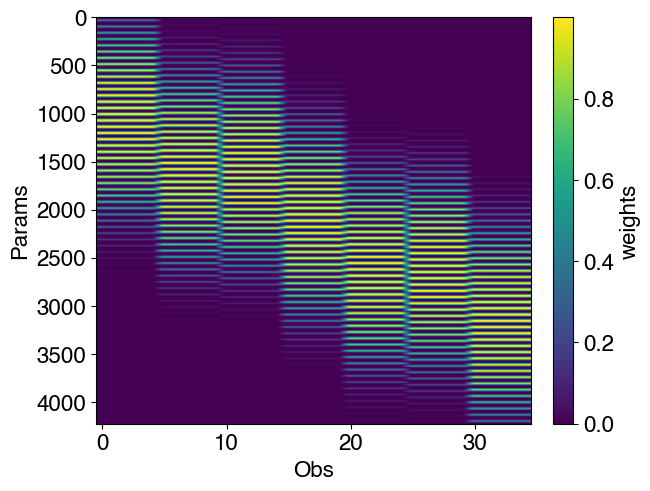

In [102]:
md_space_correlation_matrix = lil_array((coordinates.shape[0], obs_val_coords.shape[0]))

# distance matrix computation
for i, (ox, oy) in enumerate(prod_grid_coordinates):
    md_space_correlation_matrix[
        :, i * obs_size_per_well : (i + 1) * obs_size_per_well
    ] = distances_to_weights_beta_cumulative(
        distance_matrix(coordinates, [[ox, oy]]).ravel()[:, np.newaxis],
        beta=3,
        scaling_factor=150,
    )


def get_sparcity(mat: csr_array) -> float:
    return mat.count_nonzero() / np.prod(mat.shape)


logging.info(f"md_space_correlation_matrix.shape = {md_space_correlation_matrix.shape}")
logging.info(f"matrix sparcity = {get_sparcity(md_space_correlation_matrix.tocsr())}")


logging.info(f"md_space_correlation_matrix.shape = {md_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(md_space_correlation_matrix.toarray(), aspect="auto")
plt.xlabel("Obs")
plt.ylabel("Params")
plt.colorbar(label="weights")

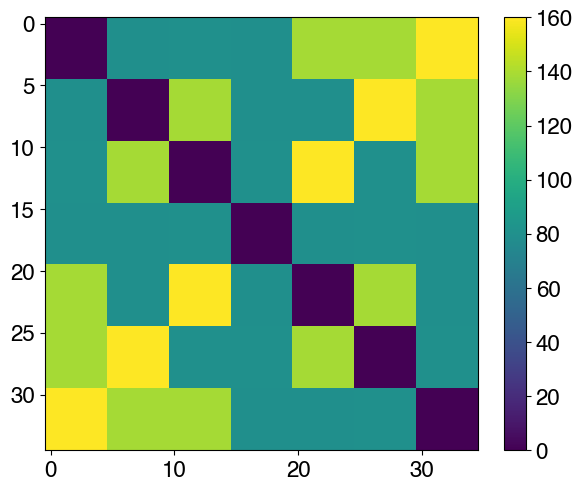

In [103]:
plt.imshow(distance_matrix(obs_val_coords, obs_val_coords))
plt.colorbar()

INFO:root:dd_space_correlation_matrix.shape = (35, 35)
INFO:root:matrix sparcity = 0.8775510204081632
INFO:root:dd_space_correlation_matrix.shape = (35, 35)


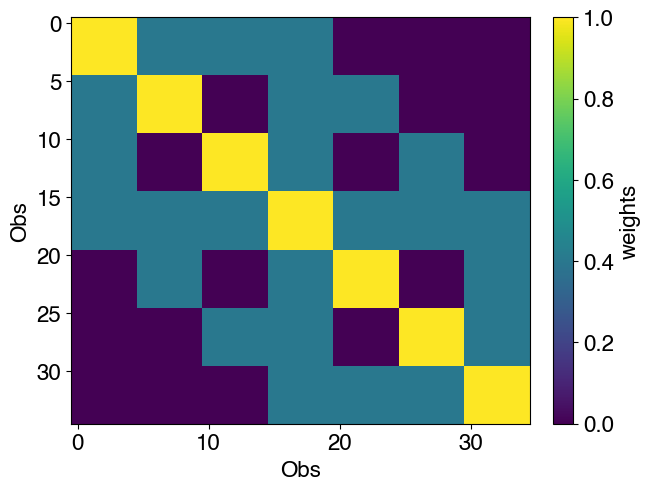

In [104]:
dd_space_correlation_matrix = csc_array(
    distances_to_weights_beta_cumulative(
        distance_matrix(obs_val_coords, obs_val_coords),
        beta=3,
        scaling_factor=150,
    )
)

logging.info(f"dd_space_correlation_matrix.shape = {dd_space_correlation_matrix.shape}")
logging.info(f"matrix sparcity = {get_sparcity(dd_space_correlation_matrix.tocsr())}")
logging.info(f"dd_space_correlation_matrix.shape = {dd_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(dd_space_correlation_matrix.toarray(), aspect="auto")
plt.xlabel("Obs")
plt.ylabel("Obs")
plt.colorbar(label="weights")

In [105]:
dd_space_correlation_matrix.shape

(35, 35)

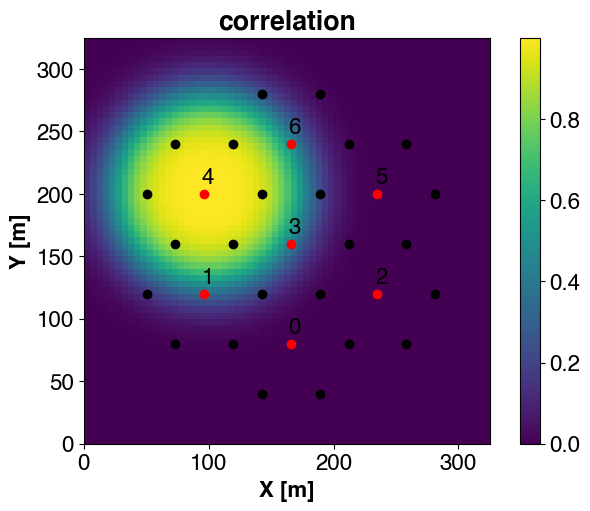

In [214]:
plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (7, 5)})
ax = plotter_wf.ax_dict["ax1-1"]

for i, j in inj_grid_coordinates:
    ax.plot(i, j, "ko")

for i, j in prod_grid_coordinates:
    ax.plot(i, j, "k^" if is_gray_scale else "ro")

patches = []
for polygon in prod_cell_polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.0)
# p.set_facecolors("white")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
ax.add_collection(p)

for i, prod_coords in enumerate(prod_grid_coordinates):
    ax.text(prod_coords[0] - 2, prod_coords[1] + 8, i)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, ny * dy)
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Y [m]", fontweight="bold")

# Add the weights
well_id = 4
fd = (
    md_space_correlation_matrix[:, [int(well_id + 0.5) * obs_size_per_well]]
    .toarray()
    .reshape(nx, ny, order="F")
)

fd = (
    md_space_correlation_matrix[:, [int(well_id + 0.5 + 1) * obs_size_per_well - 1]]
    .toarray()
    .reshape(nx, ny, order="F")
)
ix, iy = prod_grid_indices[well_id]

ngp.multi_imshow(
    axes=plotter_wf.axes[:],
    fig=plotter_wf.fig,
    data={"correlation": fd},
    imshow_kwargs={
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
        "cmap": "viridis",
    },
    is_symmetric_cbar=False,
)

In [167]:
int(well_id + 0.5) * obs_size_per_well

5

## Inversion with ESMDA

In [107]:
# TODO: IS it different if we use preconditonning ?

if is_run_esmda:
    adjusted_param_esmda = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
        ubounds=float(grade_ppm_to_mol_per_kg(1500.0)[0]),
        sp=0,
        preconditioner=dminv.ChainedTransforms(
            [
                dminv.LinearTransform(slope=1 / conv_u_grade, y_intercept=0.0),
                dminv.BoundsClipper(1.0, 2000.0),  # bounds = [1, 2000] ppm
            ]
        ),
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

    model_adjusted_esmda = copy.deepcopy(model_estimate)
    model_adjusted_esmda.time_params.duration = duration_in_seconds_inv

    inverse_model_esmda = dminv.InverseModel(adjusted_param_esmda, observables)

    # localization
    if esmda_localization_strategy == "adaptive":
        C_SD_localization = CorrelationBasedLocalization(
            CorrelationTempering(gc_correlation_tempering_positive)
        )
        # C_DD_localization=FixedLocalization(dd_space_correlation_matrix.tocsc()),
    elif esmda_localization_strategy == "fixed":
        C_SD_localization = FixedLocalization(md_space_correlation_matrix.tocsc())
        # C_DD_localization=FixedLocalization(dd_space_correlation_matrix.tocsc()),
    else:
        C_SD_localization = NoLocalization()
    C_DD_localization = NoLocalization()

    if esmda_variant == "rs":
        solver_config_esmda = dminv.ESMDARSSolverConfig(
            inversion_type=dminv.ESMDAInversionType.EXACT_CHOLESKY,
            is_parallel=True,
            max_workers=max_workers,  # max four processes in parrallel.
            save_ensembles_history=True,  # this must be ON for the plots,
            C_SD_localization=C_SD_localization,
            C_DD_localization=C_DD_localization,
            std_s_prior=np.sqrt(estimated_field_var_ppm.ravel("F")),
            # cov_ss_inflation_factor=1.2,
            truncation=0.99,
            # batch_size=1000
        )
        executor_esmda = dminv.ESMDARSInversionExecutor(
            model_adjusted_esmda,
            inverse_model_esmda,
            solver_config_esmda,
            s_init=initial_ensemble_values_ppm.T,
        )
    elif esmda_variant == "base":
        solver_config_esmda = dminv.ESMDASolverConfig(
            inversion_type=dminv.ESMDAInversionType.EXACT_CHOLESKY,
            is_parallel=True,
            max_workers=max_workers,  # max four processes in parrallel.
            save_ensembles_history=True,  # this must be ON for the plots,
            n_assimilations=1,
            C_SD_localization=C_SD_localization,
            C_DD_localization=C_DD_localization,
            # cov_ss_inflation_factor=2.0,
            truncation=0.99,
            # batch_size=1000
        )
        executor_esmda = dminv.ESMDAInversionExecutor(
            model_adjusted_esmda,
            inverse_model_esmda,
            solver_config_esmda,
            s_init=initial_ensemble_values_ppm.T,
        )
    else:
        solver_config_esmda = dminv.ESMDADMCSolverConfig(
            inversion_type=dminv.ESMDAInversionType.EXACT_CHOLESKY,
            is_parallel=True,
            max_workers=max_workers,  # max four processes in parrallel.
            save_ensembles_history=True,  # this must be ON for the plots,
            C_SD_localization=C_SD_localization,
            C_DD_localization=C_DD_localization,
            # C_DD_localization=FixedLocalization(dd_space_correlation_matrix.tocsc()),
            # cov_ss_inflation_factor=2.0,
            truncation=0.99,
            # batch_size=1000
        )
        executor_esmda = dminv.ESMDADMCInversionExecutor(
            model_adjusted_esmda,
            inverse_model_esmda,
            solver_config_esmda,
            s_init=initial_ensemble_values_ppm.T,
        )

    # Compute a first objective function
    executor_esmda.eval_scaled_loss(
        get_param_values(adjusted_param_esmda, is_preconditioned=False),
        is_save_state=False,
    )

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 9688.624476929832
INFO:root:Loss (obs fit) / Nobs = 276.8178421979952
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.00010321382590285755
INFO:root:Loss (scaled)         = 1.0



In [108]:
if is_run_esmda:
    executor_esmda.run()

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : ESMDA-DMC
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 4225
INFO:root:Number of observables                             : 7
INFO:root:Number of observation data points (values)        : 35
INFO:root:================================================================================
INFO:ESMDA-DMC:Assimilation # 1
INFO:root:- Running forward model # 1
INFO:root:- Running forward model # 2
INFO:root:- Run # 1 over
INFO:root:- Running forward model # 3
INFO:root:- Run # 2 over
INFO:root:- Running forward model # 4
INFO:root:- Run # 3 over
INFO:root:- Running forward model # 5
INFO:root:- Run # 4 over
INFO:root:- Running forward model # 6
INFO:root:- Run # 5 over
INFO:root:- Running forward model # 7
INFO:root:- Run # 6 over
INFO:root:- Running forward

KeyboardInterrupt: 

INFO:root:- Run # 23 over


### Rebuilt the esmda full history of curves.

INFO:root:esmda_loss_index = 1


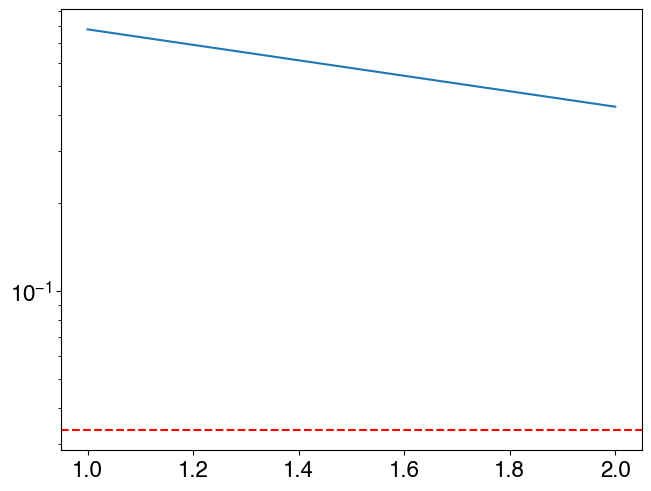

In [109]:
if is_run_esmda:
    losses_esmda: List[float] = []
    for d_pred in executor_esmda.solver.d_history:
        d_average = np.average(d_pred, axis=1)
        ls = (
            dminv.eval_loss_ls(
                d_average,
                dminv.get_observables_values_as_1d_vector(
                    executor_esmda.inv_model.observables
                ),
                dminv.get_observables_uncertainties_as_1d_vector(
                    executor_esmda.inv_model.observables
                ),
            )
            * executor_esmda.inv_model.scaling_factor
        )
        losses_esmda.append(ls)

    # losses_esmda = [loss / losses_esmda[0] for loss in losses_esmda]
    esmda_loss_index = 0

    _loss_target = (
        loss_target_fct(observables) * executor_esmda.inv_model.scaling_factor
    )

    for esmda_loss_index, loss in enumerate(losses_esmda):
        if loss < _loss_target:
            break

    logging.info(f"esmda_loss_index = {esmda_loss_index}")

    plotter = ngp.NestedGridPlotter()
    ax = plotter.axes[0]
    ax.plot(np.arange(1, len(losses_esmda) + 1), losses_esmda)
    ax.set_yscale("log")
    ax.axhline(_loss_target, linestyle="--", c="r")

    plotter.savefig(fig_save_path.joinpath("loss_ls_esmda.pdf"))

In [ ]:
if is_run_esmda:
    s_best_av_esmda_ppm = np.mean(
        executor_esmda.s_history[esmda_loss_index], axis=1
    ).reshape(nx, ny, order="F")
    s_best_av_esmda_ppm.shape

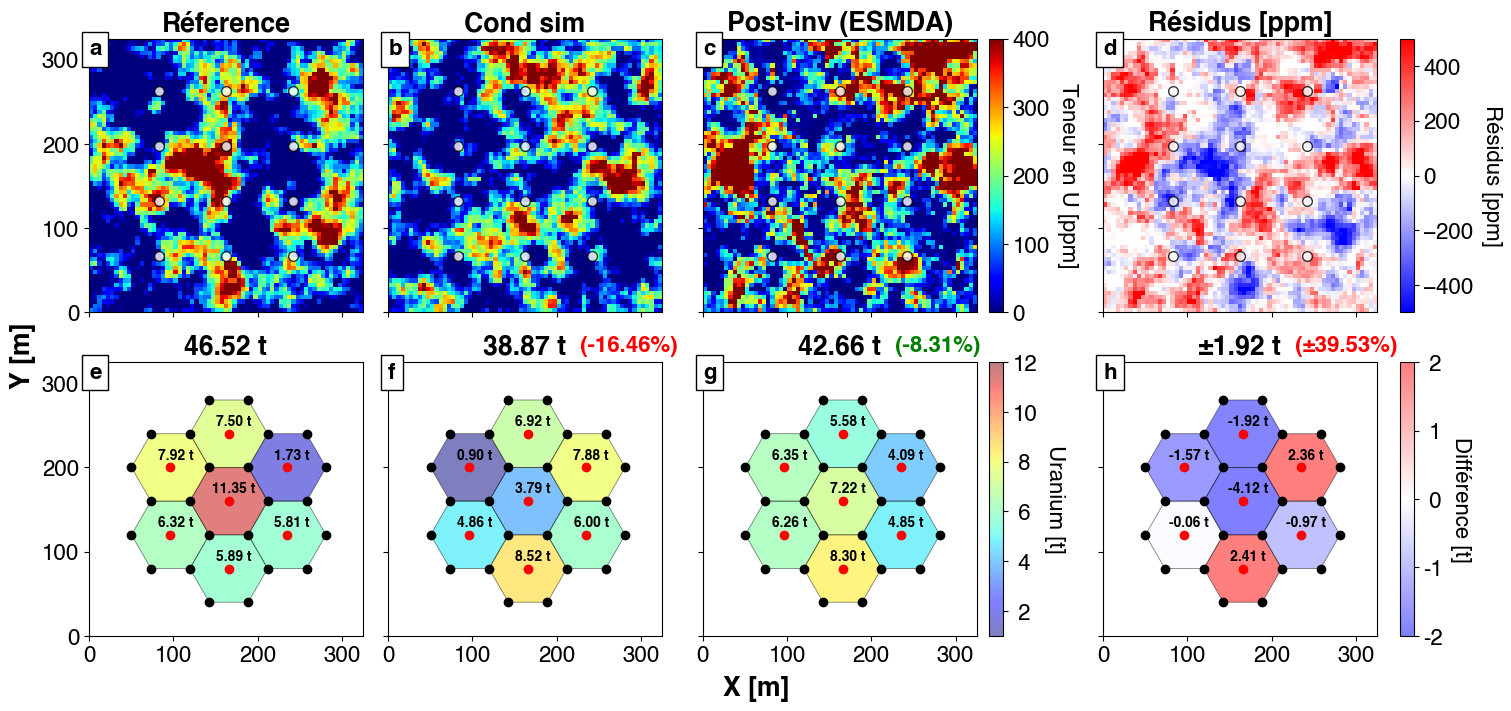

In [ ]:
if is_run_esmda:
    plot_inv_res_grade_and_tonnages(
        ref_grade=reference_grade_ppm,
        prior_grade=estimate_grade_simu_ppm,
        inversed_grade=s_best_av_esmda_ppm,
        case_name="esmda",
    )

- A posteriori error estimation

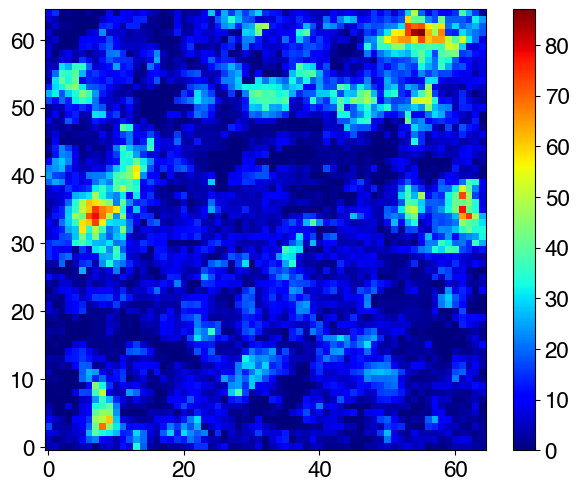

In [ ]:
if is_run_esmda:
    post_var = get_ensemble_variance(executor_esmda.s_history[esmda_loss_index])
    post_std_esmda_ppm = np.sqrt(post_var).reshape(nx, ny, order="F")
    plt.imshow(post_std_esmda_ppm.T, cmap=jet_cmap, origin="lower")
    plt.colorbar()

In [ ]:
# Function to run the model with a given uraninite field
def _run_forward_model(s, n_run) -> Tuple[NDArrayFloat, NDArrayFloat]:
    logging.info(f"Running model #{n_run}")
    _model = copy.deepcopy(model_estimate)
    _model.tr_model.set_initial_grade(s.reshape(nx, ny, order="F"))
    _solver = dmfwd.ForwardSolver(_model)
    _solver.solve()
    conc_molpl = np.zeros((len(prod_grid_coordinates), duration_in_days + 1))
    cum_prod_t = get_u_cum_prod_t_per_well_daily_basis(_model)

    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        conc_molpl[i] = interp1d(
            _model.time_params.times / 3600 / 24,
            _model.tr_model.conc[ix, iy, :],
            kind="cubic",
        )(np.arange(duration_in_days + 1))

    logging.info(f"- Running model #{n_run} - Over")
    return conc_molpl, cum_prod_t


def _map_run_froward_model(s) -> Tuple[NDArrayFloat, NDArrayFloat]:
    # We will interpolate on a daily basis
    _conc_pred = np.zeros(
        (len(prod_grid_coordinates), n_fields_es, duration_in_days + 1)
    )
    _prod_cum_pred = np.zeros_like(_conc_pred)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(
            _run_forward_model,
            s.T,
            list(range(n_fields_es)),
        )
        for j, (_conc, _cum) in enumerate(results):
            # avoid shape mismatch
            _conc_pred[:, j, :] = _conc
            _prod_cum_pred[:, j, :] = _cum

    # for j, _s in enumerate(s.T):
    #     _d_pred[:, j, :] = _run_forward_model(_s, j)

    return _conc_pred, _prod_cum_pred


if is_run_esmda:
    s_init = grade_ppm_to_mol_per_kg(executor_esmda.s_history[0])
    s_final = grade_ppm_to_mol_per_kg(executor_esmda.s_history[esmda_loss_index])

    (
        u_conc_pred_molpl_init_esmda,
        u_prod_cum_pred_t_init_esmda,
    ) = _map_run_froward_model(s_init)
    (
        u_conc_pred_molpl_final_esmda,
        u_prod_cum_pred_t_final_esmda,
    ) = _map_run_froward_model(s_final)

INFO:root:Running model #0
INFO:root:Running model #1
INFO:root:- Running model #0 - Over
INFO:root:Running model #2
INFO:root:- Running model #1 - Over
INFO:root:Running model #3
INFO:root:- Running model #2 - Over
INFO:root:Running model #4
INFO:root:- Running model #3 - Over
INFO:root:- Running model #4 - Over
INFO:root:Running model #0
INFO:root:Running model #1
INFO:root:- Running model #0 - Over
INFO:root:Running model #2
INFO:root:- Running model #1 - Over
INFO:root:Running model #3


In [ ]:
if is_run_esmda:
    model_estimate.time_params.nt

In [ ]:
def plot_inv_res_conc_at_producers_ensemble(
    *,
    ref_model: dmfwd.ForwardModel,
    prior_model: dmfwd.ForwardModel,
    d_pred_init: Optional[NDArrayFloat] = None,
    d_pred_final: Optional[NDArrayFloat] = None,
    case_name: str,
) -> ngp.NestedGridPlotter:
    """

    Parameters
    ----------
    ref_model : _type_
        _description_
    prior_model : _type_
        _description_
    inversed_model : _type_
        _description_

    Returns
    -------
    NestedGridPlotter
        _description_
    """
    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 8)},
        subfigs_params={
            "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
        },
        subplots_mosaic_params={
            "left_col": dict(
                mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
            "centered_col": dict(
                mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
            ),
            "right_col": dict(
                mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
        },
    )

    # hide axes and borders
    plotter.ax_dict["ghost1"].axis("off")
    plotter.ax_dict["ghost2"].axis("off")
    plotter.ax_dict["ghost3"].axis("off")
    plotter.ax_dict["ghost4"].axis("off")

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy
        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

        if language == Lg.ENGLISH:
            labels = ["Reference noisy", "Reference", "A priori"]
        else:
            labels = ["Réference bruitée", "Réference", "A priori"]
        data = {
            labels[0]: {
                "x": obs_times_in_d,
                "y": conc_molpl_to_mgpl(obs_values[count, :]),
                "kwargs": kwargs_obs_conc_points,
                # {
                #     "c": "b",
                #     "marker": "o",
                #     "linestyle": "None",
                #     "alpha": 0.3,
                #     "zorder": 10,
                # },
            },
            labels[1]: {
                "x": ref_model.time_params.times / 3600 / 24,
                "y": conc_molpl_to_mgpl(ref_model.tr_model.conc[ix, iy, :]),
                "kwargs": kwargs_obs_conc_curve,
            },
            labels[2]: {
                "x": prior_model.time_params.times / 3600 / 24,
                "y": conc_molpl_to_mgpl(prior_model.tr_model.conc[ix, iy, :]),
                "kwargs": kwargs_ig_conc_curve,
            },
        }

        for k, v in data.items():
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

        # plot the ensemble results (initial)
        # d_pred = d_history[0]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="grey", alpha=0.2, label="initial ensemble", linestyle="-")

        # d_pred = d_history[-1]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="blue", alpha=0.3, label="final ensemble", linestyle="-")

        if language == Lg.ENGLISH:
            labels = [
                "Initial ensemble",
                "Final ensemble",
                "Initial ensemble average",
                "Final ensemble average",
            ]
        else:
            labels = [
                "Ensemble initial",
                "Ensemble final",
                "Moyenne ensemble initial",
                "Moyenne ensemble final",
            ]

        d_pred_times = np.arange(duration_in_days + 1)[:, np.newaxis]

        if d_pred_init is not None:
            d_pred = d_pred_init[count]
            ax.plot(
                np.repeat(
                    d_pred_times,
                    d_pred.shape[0],
                    axis=1,
                ),
                conc_molpl_to_mgpl(d_pred.T),
                c="grey",
                alpha=0.1,
                label=labels[0],
                linestyle="-",
                zorder=1,
            )
            ax.plot(
                d_pred_times,
                conc_molpl_to_mgpl(np.mean(d_pred, axis=0)),
                c="k",
                alpha=1.0,
                zorder=5,
                label=labels[2],
                linestyle="-.",
            )

        if d_pred_final is not None:
            d_pred = d_pred_final[count]
            ax.plot(
                np.repeat(
                    d_pred_times,
                    d_pred.shape[0],
                    axis=1,
                ),
                conc_molpl_to_mgpl(d_pred.T),
                c="grey",
                alpha=0.3,
                label=labels[1],
                linestyle="-",
                zorder=1,
            )
            ax.plot(
                d_pred_times,
                conc_molpl_to_mgpl(np.mean(d_pred, axis=0)),
                c="k",
                alpha=1.0,
                zorder=5,
                label=labels[3],
                linestyle="-.",
            )

        if language == Lg.ENGLISH:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="inversion period",
            )
        else:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="Période inversion",
            )

        # d_pred = d_history[-1]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="blue", alpha=0.3, label="final ensemble", linestyle="-")

    plotter.add_fig_legend(ncol=3)
    if language == Lg.ENGLISH:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = "U_at_producers_post_inv_esmda"
    for format in ["png", "pdf", "svg"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)
    return plotter

In [ ]:
if is_run_esmda:
    plot_inv_res_conc_at_producers_ensemble(
        ref_model=model_reference,
        prior_model=model_estimate,
        d_pred_init=u_conc_pred_molpl_init_esmda,
        # d_pred_final=u_conc_pred_molpl_final_esmda,
        case_name="esmda_init",
    )

In [ ]:
if is_run_esmda:
    plot_inv_res_conc_at_producers_ensemble(
        ref_model=model_reference,
        prior_model=model_estimate,
        # d_pred_init=u_conc_pred_molpl_init_esmda,
        d_pred_final=u_conc_pred_molpl_final_esmda,
        case_name="esmda_final",
    )

In [ ]:
from pyrtid.plot import plot_percentiles

In [ ]:
if is_run_esmda:
    plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
    ax = plotter.axes[0]
    times = model_reference.time_params.times / 24 / 3600
    times_d = np.arange(u_cum_prod_ref_t.size)
    plot_percentiles(
        ax,
        np.sum(u_prod_cum_pred_t_final_esmda, axis=0).T,
        x=times_d,
        cmap=plt.get_cmap("Greys"),
    )

    if language == Lg.ENGLISH:
        xlabel = "Time [d]"
        ylabel = "Cumulative production [t]"
        ig_label = "Initial guess"
        ref_label = "Reference"
    else:
        xlabel = "Temps [j]"
        ylabel = "Producion cumulée [t]"
        ig_label = "Avant inversion"
        ref_label = "Réference"

    ax.plot(times_d, u_cum_prod_ref_t, label=ref_label, linestyle=":", c="k")
    ax.plot(times_d, u_cum_prod_ig_t, label=ig_label, linestyle="--", c="k")

    ax.set_xlabel(xlabel, fontweight="bold")
    ax.set_ylabel(ylabel, fontweight="bold")
    # ax.legend(ncols=2)

    if language == Lg.ENGLISH:
        ax.axvspan(
            0,
            obs_times_in_d[-1],
            color="grey",
            alpha=0.25,
            label="inversion period",
        )
    else:
        ax.axvspan(
            0,
            obs_times_in_d[-1],
            color="grey",
            alpha=0.25,
            label="Période inversion",
        )

    ax.set_xlim(0.0, ax.get_xlim()[1])
    ax.set_ylim(0.0, ax.get_ylim()[1])

    plotter.add_fig_legend("fig1-1", ncols=4, bbox_y_shift=-0.09)

    fname = "esmda_prod_uncertainty"
    for format in ["png", "pdf", "svg"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Inversion with SIES

In [ ]:
if is_run_sies:
    adjusted_param_sies = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=float(grade_ppm_to_mol_per_kg(1.0)[0]),
        ubounds=float(grade_ppm_to_mol_per_kg(1500.0)[0]),
        sp=0,
        preconditioner=dminv.ChainedTransforms(
            [
                dminv.LinearTransform(slope=1 / conv_u_grade, y_intercept=0.0),
                dminv.BoundsClipper(1.0, 2000.0),  # bounds = [1, 2000] ppm
            ]
        ),
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

    model_adjusted_sies = copy.deepcopy(model_estimate)
    model_adjusted_sies.time_params.duration = duration_in_seconds_inv

    inverse_model_sies = dminv.InverseModel(adjusted_param_sies, observables)

    solver_config_sies = dminv.SIESSolverConfig(
        inversion_type=dminv.SIESInversionType.SUBSPACE_EXACT,
        is_parallel=True,
        max_workers=max_workers,  # max four processes in parrallel.
        save_ensembles_history=True,  # this must be ON for the plots,
        truncation=0.99,
        seed=2023,
        # batch_size=1000
    )

    executor_sies = dminv.SIESInversionExecutor(
        model_adjusted_sies,
        inverse_model_sies,
        solver_config_sies,
        s_init=initial_ensemble_values_molpl.T,
    )

    # Compute a first objective function
    executor_sies.eval_scaled_loss(
        get_param_values(adjusted_param_sies, is_preconditioned=False),
        is_save_state=False,
    )

In [ ]:
if is_run_sies:
    executor_sies.run()

- Rebuild SIES full history of curves

In [ ]:
if is_run_sies:
    losses_sies: List[float] = []
    for d_pred in executor_sies.solver.d_history:
        d_average = np.average(d_pred, axis=1)
        ls = (
            dminv.eval_loss_ls(
                d_average,
                dminv.get_observables_values_as_1d_vector(
                    executor_sies.inv_model.observables
                ),
                dminv.get_observables_uncertainties_as_1d_vector(
                    executor_sies.inv_model.observables
                ),
            )
            * executor_sies.inv_model.scaling_factor
        )
        losses_sies.append(ls)

    # losses_sies = [loss / losses_sies[0] for loss in losses_sies]
    sies_loss_index = 0

    _loss_target = loss_target_fct(observables) * executor_sies.inv_model.scaling_factor

    for sies_loss_index, loss in enumerate(losses_sies):
        if loss < _loss_target:
            break

    logging.info(f"sies_loss_index = {sies_loss_index}")
    plotter = ngp.NestedGridPlotter()
    ax = plotter.axes[0]
    ax.plot(losses_sies)
    ax.set_yscale("log")
    plotter.savefig(fig_save_path.joinpath("sies_obj_fun.pdf"))

In [ ]:
if is_run_sies:
    s_init = executor_sies.s_history[0]
    s_final = executor_sies.s_history[sies_loss_index]

    (
        u_conc_pred_molpl_init_sies,
        u_prod_cum_pred_t_init_sies,
    ) = _map_run_froward_model(s_init)
    u_conc_pred_molpl_final_sies, u_prod_cum_pred_t_final_sies = _map_run_froward_model(
        s_final
    )

In [ ]:
if is_run_sies:
    plot_inv_res_conc_at_producers_ensemble(
        ref_model=model_reference,
        prior_model=model_estimate,
        d_pred_init=u_conc_pred_molpl_init_sies,
        d_pred_final=u_conc_pred_molpl_final_sies,
        case_name="sies",
    )

In [ ]:
if is_run_sies:
    s_best_av_sies_ppm = np.mean(
        executor_sies.s_history[sies_loss_index], axis=1
    ).reshape(nx, ny, order="F")
    s_best_av_sies_ppm.shape

    plot_inv_res_grade_and_tonnages(
        ref_grade=reference_grade_ppm,
        prior_grade=estimate_grade_simu_ppm,
        inversed_grade=s_best_av_sies_ppm,
        case_name="sies",
    )

In [ ]:
if is_run_sies:
    post_var = get_ensemble_variance(executor_sies.s_history[sies_loss_index])
    post_std_sies_ppm: NDArrayFloat = np.sqrt(post_var).reshape(nx, ny, order="F")
    plt.imshow(post_std_sies_ppm.T, cmap=jet_cmap, origin="lower")
    plt.colorbar()

# Comparision

In [ ]:
if is_run_all:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (11.0, 7.0)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1", "ax1-2", "ax1-3"], ["ax2-1", "ax2-2", "ax2-3"]],
                sharey=True,
                sharex=True,
            )
        },
    )

    if language == Lg.ENGLISH:
        labels = [
            "PCGA - 1.96 \u03c3",
            "ESMDA - 1.96 \u03c3",
            "SIES - 1.96 \u03c3",
            "Residuals PCGA",
            "Residuals ESMDA",
            "Residuals SIES",
        ]
        cbar_title = "Uranium grade [ppm]"
    else:
        labels = [
            "PCGA - 1.96 \u03c3",
            "ESMDA - 1.96 \u03c3",
            "SIES - 1.96 \u03c3",
            "Résidus PCGA",
            "Résidus ESMDA",
            "Résidus SIES",
        ]
        cbar_title = "Teneur en U [ppm]"

    ngp.multi_imshow(
        axes=plotter.axes,
        fig=plotter.fig,
        data={
            labels[0]: np.sqrt(post_diagv_best_pcga).reshape(nx, ny, order="F") * 1.96,
            labels[1]: post_std_esmda_ppm * 1.96,
            labels[2]: post_std_sies_ppm * 1.96,
            labels[3]: np.abs(reference_grade_ppm - _s_inversed_best_pcga_ppm),
            labels[4]: np.abs(reference_grade_ppm - s_best_av_esmda_ppm),
            labels[5]: np.abs(reference_grade_ppm - s_best_av_sies_ppm),
        },
        cbar_title=cbar_title,
        imshow_kwargs={
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 100,
            "vmax": 250,
            "aspect": "equal",
        },
        cbar_kwargs={"pad": 0.01},
        xlabel="X [m]",
        ylabel="Y [m]",
    )

    for ax in plotter.axes:
        # plot the sampling points here
        ax.plot(
            (dat_coords[0] + 0.5) * dx,
            (dat_coords[1] * dy),
            linestyle="None",
            marker="o",
            markersize=7,
            color="k",
            markerfacecolor="None",
        )

    ngp.add_letter_to_frames(plotter.axes)

    fname = "uncertainties_and_residuals_pcga_esmda_sies"
    for format in ["png", "pdf", "svg"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )

- Plot inversion results

In [ ]:
def plot_inv_res_grade_and_tonnages_comp(*, data) -> ngp.NestedGridPlotter:
    ncols = len(data.keys())
    plotter = ngp.NestedGridPlotter(
        fig_params={
            "constrained_layout": True,
            "figsize": (3.15 * ncols + 2, 10.5),
        },  # (11.5, 10.5)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[[f"ax{i}-{j}" for j in range(ncols)] for i in range(3)],
                sharey=True,
                sharex=True,
            )
        },
    )

    data_tonnages = {}
    for k, v in data.items():
        data_tonnages[k] = get_sel_u_tonnages(
            v, prod_cells_selection_array, geom=geometry
        )

    if language == Lg.ENGLISH:
        cbar_title = "Uranium grade [ppm]"
    else:
        cbar_title = "Teneur en U [ppm]"

    # 1) Plot the grades
    cbar_up = ngp.multi_imshow(
        axes=plotter.axes[:ncols],
        fig=plotter.fig,
        data=data,
        cbar_title=cbar_title,
        imshow_kwargs={
            "cmap": jet_cmap,
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0,
            "vmax": 400,
        },
        cbar_kwargs={"pad": 0.01},
    )
    # Add sampling points but only on grades
    add_sampling_points(plotter.axes[:ncols])

    # 2) Plot the tonnages
    plot_tonnages(
        plotter.fig,
        plotter.axes[ncols : ncols * 2],
        (list(data.values())),
        ref_axis=0,
        is_use_extended_cells=False,
    )

    # 3) Plot the tonnages deviation
    plot_tonnages_deviations(
        plotter.fig,
        plotter.axes[ncols * 2 :],
        (list(data.values())),
        ref_axis=0,
        is_use_extended_cells=False,
    )

    ngp.add_letter_to_frames(plotter.axes)

    # Box dimensions
    for ax in plotter.ax_dict.values():
        ax.set_xlim(0, nx * dx)
        ax.set_ylim(0, ny * dy)
        ax.set_aspect("equal", adjustable="box")

    # plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
    plotter.fig.supxlabel("X [m]", fontweight="bold")
    plotter.fig.supylabel("Y [m]", fontweight="bold")

    # Add letters a, b, c, ...
    ngp.add_letter_to_frames(plotter.axes)

    fname = "tonnages_and_grades_per_cells_post_inv_comp"
    for format in ["png", "pdf", "svg"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )
    return plotter

In [ ]:
data = {"REFERENCE": reference_grade_ppm}

if is_run_asm:
    data["ASM"] = grade_mol_per_kg_to_ppm(adjusted_param_adjoint.values)
if is_run_pcga:
    data["PCGA"] = _s_inversed_best_pcga_ppm
if is_run_esmda:
    data["ESMDA"] = s_best_av_esmda_ppm
if is_run_sies:
    data["SIES"] = s_best_av_sies_ppm


plot_inv_res_grade_and_tonnages_comp(data=data)

- Plot the comparision in terms of number of runs

In [ ]:
labels = []
n_runs_adjoint = []
n_runs_forward = []

if is_run_asm:
    labels.append("ASM")
    n_runs_adjoint.append(executor_adjoint.inv_model.nb_g_calls)
    n_runs_forward.append(executor_adjoint.inv_model.nb_f_calls)
if is_run_pcga:
    labels.append("PCGA")
    n_runs_adjoint.append(0)
    n_runs_forward.append(executor_pcga.inv_model.nb_f_calls)
if is_run_esmda:
    labels.append("ESMDA")
    n_runs_adjoint.append(0)
    n_runs_forward.append(
        initial_ensemble_values_molpl.shape[0] * (esmda_loss_index + 1)
    )
if is_run_sies:
    labels.append("SIES")
    n_runs_adjoint.append(0)
    n_runs_forward.append(
        initial_ensemble_values_molpl.shape[0] * (sies_loss_index + 1)
    )

width = 0.35

fig, ax = plt.subplots(figsize=(5.3, 4))
fig.patch.set_facecolor("w")

if language == Lg.ENGLISH:
    bars = ax.bar(labels, n_runs_forward, width, label="Forward", color="k")
else:
    bars = ax.bar(labels, n_runs_forward, width, label="Direct", color="k")
ax.bar(
    labels,
    n_runs_adjoint,
    width,
    label="Adjoint",
    bottom=n_runs_forward,
    color="grey",
)

if language == Lg.ENGLISH:
    ax.set_ylabel("Simulations nb.", weight="bold")
    ax.set_title("Number of runs", weight="bold")
else:
    ax.set_ylabel("Nombre de simulations", weight="bold")
    ax.set_title("Nombre de simulations", weight="bold")

ax.set_ylim(0, max(n_runs_forward) * 1.1)
ax.legend()

for bar, n_fwd, n_adj in zip(bars, n_runs_forward, n_runs_adjoint):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        (bar.get_height() / n_fwd) * (n_fwd + n_adj) + 1.5,
        round((n_fwd + n_adj), 1),
        horizontalalignment="center",
        color="k",
        weight="bold",
    )

fname = "n_runs_comp_french"
for format in ["png", "pdf", "svg"]:
    fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

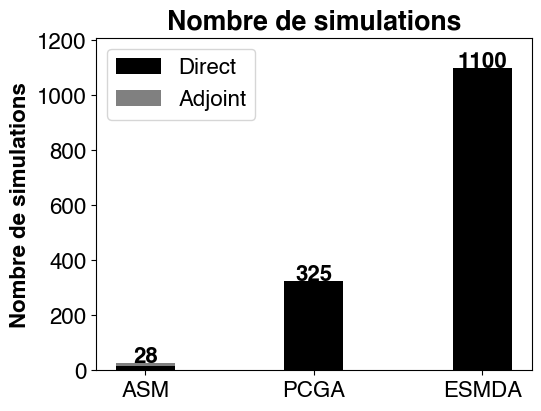

In [12]:
labels = ["ASM", "PCGA", "ESMDA"]
n_runs_adjoint = [14, 0, 0]
n_runs_forward = [14, 325, 1100]

width = 0.35

fig, ax = plt.subplots(figsize=(5.3, 4))
fig.patch.set_facecolor("w")

if language == Lg.ENGLISH:
    bars = ax.bar(labels, n_runs_forward, width, label="Forward", color="k")
else:
    bars = ax.bar(labels, n_runs_forward, width, label="Direct", color="k")
ax.bar(
    labels,
    n_runs_adjoint,
    width,
    label="Adjoint",
    bottom=n_runs_forward,
    color="grey",
)

if language == Lg.ENGLISH:
    ax.set_ylabel("Simulations nb.", weight="bold")
    ax.set_title("Number of runs", weight="bold")
else:
    ax.set_ylabel("Nombre de simulations", weight="bold")
    ax.set_title("Nombre de simulations", weight="bold")

ax.set_ylim(0, max(n_runs_forward) * 1.1)
ax.legend()

for bar, n_fwd, n_adj in zip(bars, n_runs_forward, n_runs_adjoint):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        (bar.get_height() / n_fwd) * (n_fwd + n_adj) + 1.5,
        round((n_fwd + n_adj), 1),
        horizontalalignment="center",
        color="k",
        weight="bold",
    )

fname = "n_runs_comp_french"
for format in ["png", "pdf", "svg"]:
    fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)